# Energy Data Engineering 2 Semester project 2 "Classification''


## Created by Team 4:

    1-Saurav Bhowmick
    2-Noor Eldin Alkiswani
    
## Topic:

    Fossil Hard Coal: „High“ if > 3000 MW, Else „Low“
    
## Date:

    15-07-2024

### Insert Nessesry libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
import plotly.express as px
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score, roc_curve
from sklearn.utils import compute_sample_weight
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


###  Data Loading and cleaning

In [2]:
# Load the Data
df1 = pd.read_csv('Actual Generation per Production Type_202301010000-202401010000.csv')
df2 = pd.read_csv('Actual Generation per Production Type_202401010000-202501010000.csv')

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Drop irrelevant columns

columns_to_drop = ['Area',
    'Biomass  - Actual Aggregated [MW]', 'Fossil Brown coal/Lignite  - Actual Aggregated [MW]',
    'Fossil Coal-derived gas  - Actual Aggregated [MW]', 'Fossil Gas  - Actual Aggregated [MW]',
    'Fossil Oil  - Actual Aggregated [MW]', 'Fossil Oil shale  - Actual Aggregated [MW]',
    'Fossil Peat  - Actual Aggregated [MW]', 'Hydro Pumped Storage  - Actual Aggregated [MW]',
    'Hydro Pumped Storage  - Actual Consumption [MW]', 'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
    'Hydro Water Reservoir  - Actual Aggregated [MW]', 'Marine  - Actual Aggregated [MW]', 
    'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Extract the date from 'MTU' and convert to datetime
df['Date'] = pd.to_datetime(df['MTU'].str.split(' - ', expand=True)[0], format='%d.%m.%Y %H:%M')

# Set the 'Date' as the index
df.set_index('Date', inplace=True)

# Filter the data up to the end of July 11, 2024
end_date = pd.to_datetime('2024-07-11 23:45')
df = df[df.index <= end_date]

# Replace 'n/e' with NaN
df.replace('n/e', np.nan, inplace=True)

# Drop the 'MTU' column as it's no longer needed
df.drop(['MTU'], axis=1, inplace=True)

# Convert all relevant columns to numeric, forcing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for missing values in each column
missing_data_summary = df.isna().sum()
print("Missing data summary:\n", missing_data_summary)

# Check the number of rows with missing values
rows_with_missing_values = df.isna().any(axis=1).sum()
print("Number of rows with missing values:", rows_with_missing_values)

# Check the total number of entries
total_entries = len(df)
print(f"Total number of data entries up to {end_date}: {total_entries}")

# Show the first few rows of the cleaned data
print(df.head())


Missing data summary:
 Fossil Hard coal  - Actual Aggregated [MW]     8
Geothermal  - Actual Aggregated [MW]           8
Other renewable  - Actual Aggregated [MW]      8
Solar  - Actual Aggregated [MW]               16
Waste  - Actual Aggregated [MW]               16
Wind Offshore  - Actual Aggregated [MW]        8
Wind Onshore  - Actual Aggregated [MW]        16
dtype: int64
Number of rows with missing values: 16
Total number of data entries up to 2024-07-11 23:45:00: 53572
                     Fossil Hard coal  - Actual Aggregated [MW]  \
Date                                                              
2023-01-01 00:00:00                                      2068.0   
2023-01-01 00:15:00                                      2072.0   
2023-01-01 00:30:00                                      2068.0   
2023-01-01 00:45:00                                      2062.0   
2023-01-01 01:00:00                                      2053.0   

                     Geothermal  - Actual Aggregat

In [3]:
# Impute missing values with a consistent method (mean in this example)
df.fillna(df.mean(), inplace=True)

# Verify that all missing values have been filled
missing_data_summary_after = df.isnull().sum()
print("Missing data summary after imputation:\n", missing_data_summary_after)

# Show the first few rows of the cleaned data
print(df.head())

Missing data summary after imputation:
 Fossil Hard coal  - Actual Aggregated [MW]    0
Geothermal  - Actual Aggregated [MW]          0
Other renewable  - Actual Aggregated [MW]     0
Solar  - Actual Aggregated [MW]               0
Waste  - Actual Aggregated [MW]               0
Wind Offshore  - Actual Aggregated [MW]       0
Wind Onshore  - Actual Aggregated [MW]        0
dtype: int64
                     Fossil Hard coal  - Actual Aggregated [MW]  \
Date                                                              
2023-01-01 00:00:00                                      2068.0   
2023-01-01 00:15:00                                      2072.0   
2023-01-01 00:30:00                                      2068.0   
2023-01-01 00:45:00                                      2062.0   
2023-01-01 01:00:00                                      2053.0   

                     Geothermal  - Actual Aggregated [MW]  \
Date                                                        
2023-01-01 00:00:00

In [4]:
df.describe()

Fossil Hard coal  - Actual Aggregated [MW]  \
count                                53572.000000   
mean                                  3956.891905   
std                                   3068.614073   
min                                    333.000000   
25%                                   1823.000000   
50%                                   2870.000000   
75%                                   5143.000000   
max                                  15256.000000   

       Geothermal  - Actual Aggregated [MW]  \
count                          53572.000000   
mean                              22.966246   
std                                5.283349   
min                                5.000000   
25%                               20.000000   
50%                               23.000000   
75%                               27.000000   
max                               33.000000   

       Other renewable  - Actual Aggregated [MW]  \
count                               53572.000000   
mean                                  100.741786   
std                                    29.973514   
min                                    52.000000   
25%                                    81.000000   
50%                                    97.000000   
75%                                   123.000000   
max                                   175.000000   

       Solar  - Actual Aggregated [MW]  Waste  - Actual Aggregated [MW]  \
count                     53572.000000                     53572.000000   
mean                       6887.960453                       750.976977   
std                       10438.187132                       123.660490   
min                           0.000000                       259.000000   
25%                           2.000000                       668.000000   
50%                         204.500000                       778.000000   
75%                       11195.250000                       843.000000   
max                       48933.000000                      1011.000000   

       Wind Offshore  - Actual Aggregated [MW]  \
count                             53572.000000   
mean                               2846.631973   
std                                1862.306334   
min                                   0.000000   
25%                                1161.750000   
50%                                2681.000000   
75%                                4371.000000   
max                                7640.000000   

       Wind Onshore  - Actual Aggregated [MW]  
count                            53572.000000  
mean                             13606.048043  
std                              10365.782873  
min                                123.000000  
25%                               5253.000000  
50%                              10921.500000  
75%                              19649.250000  
max                              48340.000000

In [5]:
#Shape of Dataset
df.shape

(53572, 7)

## Task 1:  Exploratory Data Analysis 

### 1.1 Create a binary classification setting with the labels „High“ and „Low“ using the thresholds mentioned

In [6]:
threshold = 3000

# Create the binary target variable
df['Hard_coal_production_binary'] = np.where(df['Fossil Hard coal  - Actual Aggregated [MW]'] > threshold, 'High', 'Low')

# Convert binary target to numeric
df['Hard_coal_production_binary_numeric'] = df['Hard_coal_production_binary'].map({'Low': 0, 'High': 1})

# Verify the target variable
print(df['Hard_coal_production_binary_numeric'].value_counts())


Hard_coal_production_binary_numeric
0    28018
1    25554
Name: count, dtype: int64


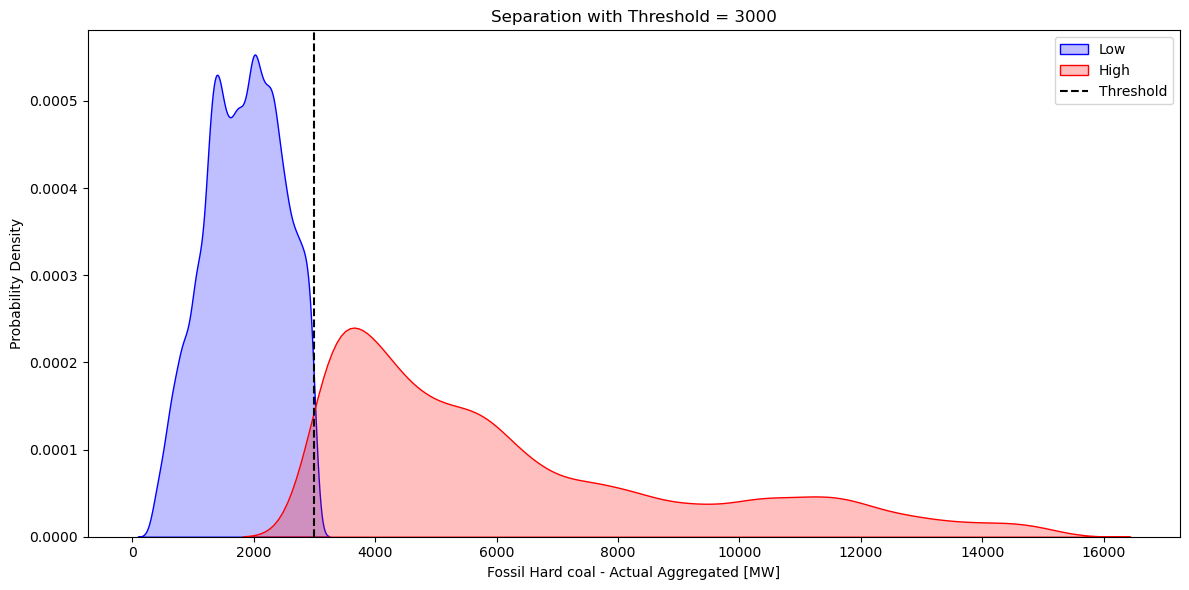

In [7]:
   # Plotting the separation of classes
plt.figure(figsize=(12, 6))

sns.kdeplot(df[df['Hard_coal_production_binary_numeric'] == 0]['Fossil Hard coal  - Actual Aggregated [MW]'], color='blue', shade=True, label='Low')
sns.kdeplot(df[df['Hard_coal_production_binary_numeric'] == 1]['Fossil Hard coal  - Actual Aggregated [MW]'], color='red', shade=True, label='High')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title(f'Separation with Threshold = {threshold}')
plt.xlabel('Fossil Hard coal - Actual Aggregated [MW]')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()



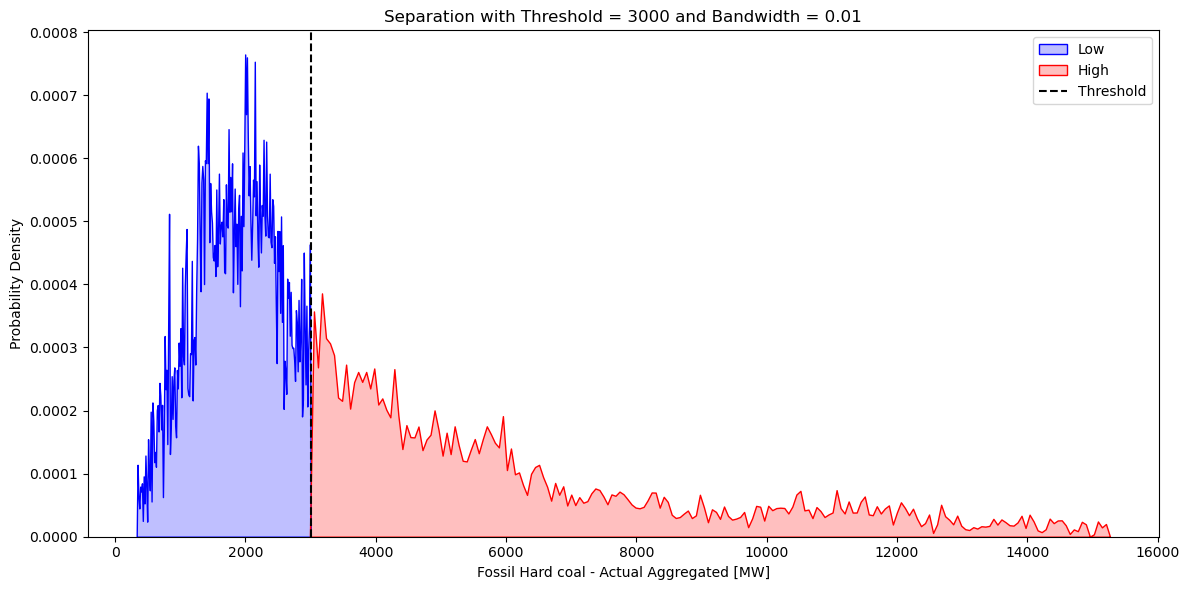

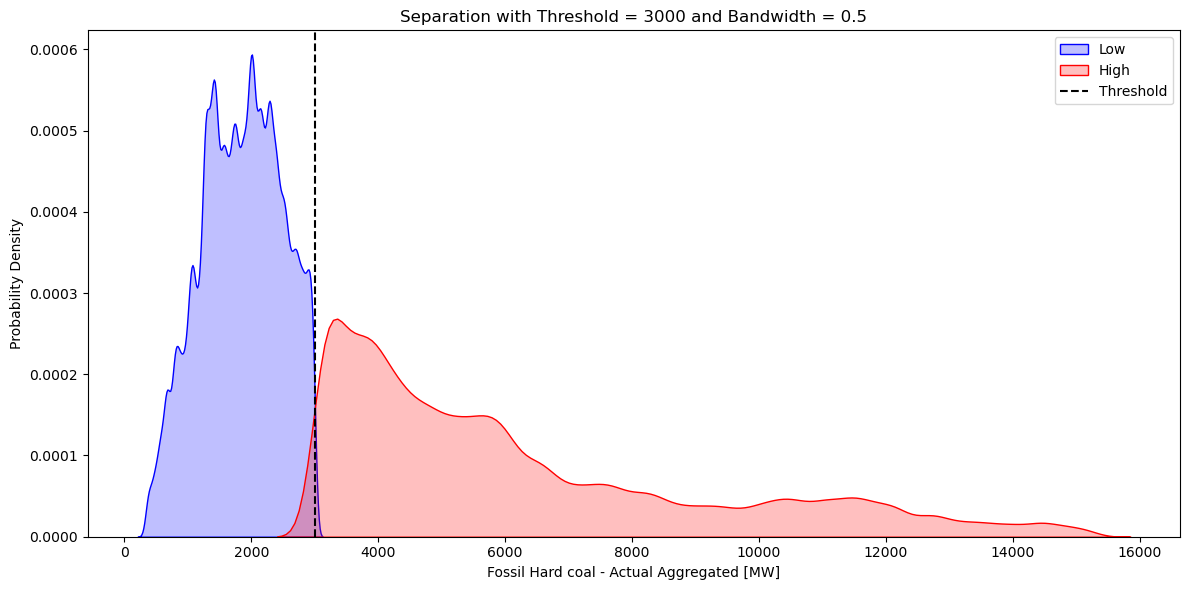

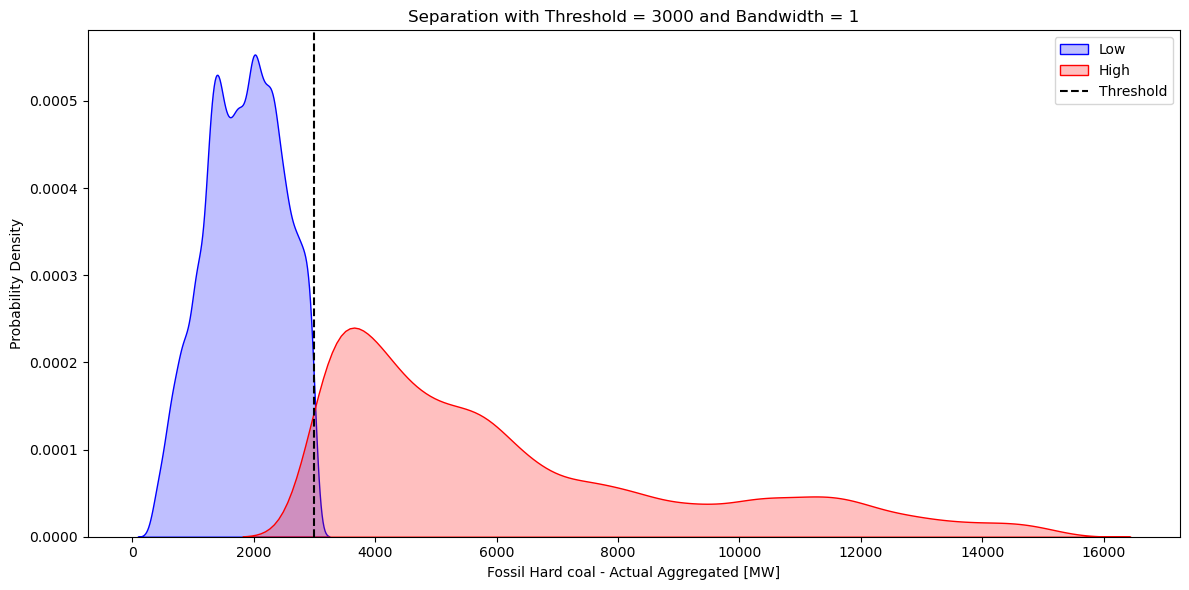

In [59]:
import seaborn as sns

# Adjust the bandwidth parameter to see different levels of smoothness
bandwidth_values = [0.01, 0.5, 1]

for bw in bandwidth_values:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df[df['Hard_coal_production_binary_numeric'] == 0]['Fossil Hard coal  - Actual Aggregated [MW]'], 
                color='blue', shade=True, label='Low', bw_adjust=bw)
    sns.kdeplot(df[df['Hard_coal_production_binary_numeric'] == 1]['Fossil Hard coal  - Actual Aggregated [MW]'], 
                color='red', shade=True, label='High', bw_adjust=bw)
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title(f'Separation with Threshold = {threshold} and Bandwidth = {bw}')
    plt.xlabel('Fossil Hard coal - Actual Aggregated [MW]')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


### 1.2 Create three concise and meaningful visualizations of your data exploring the relationship of features and target variables

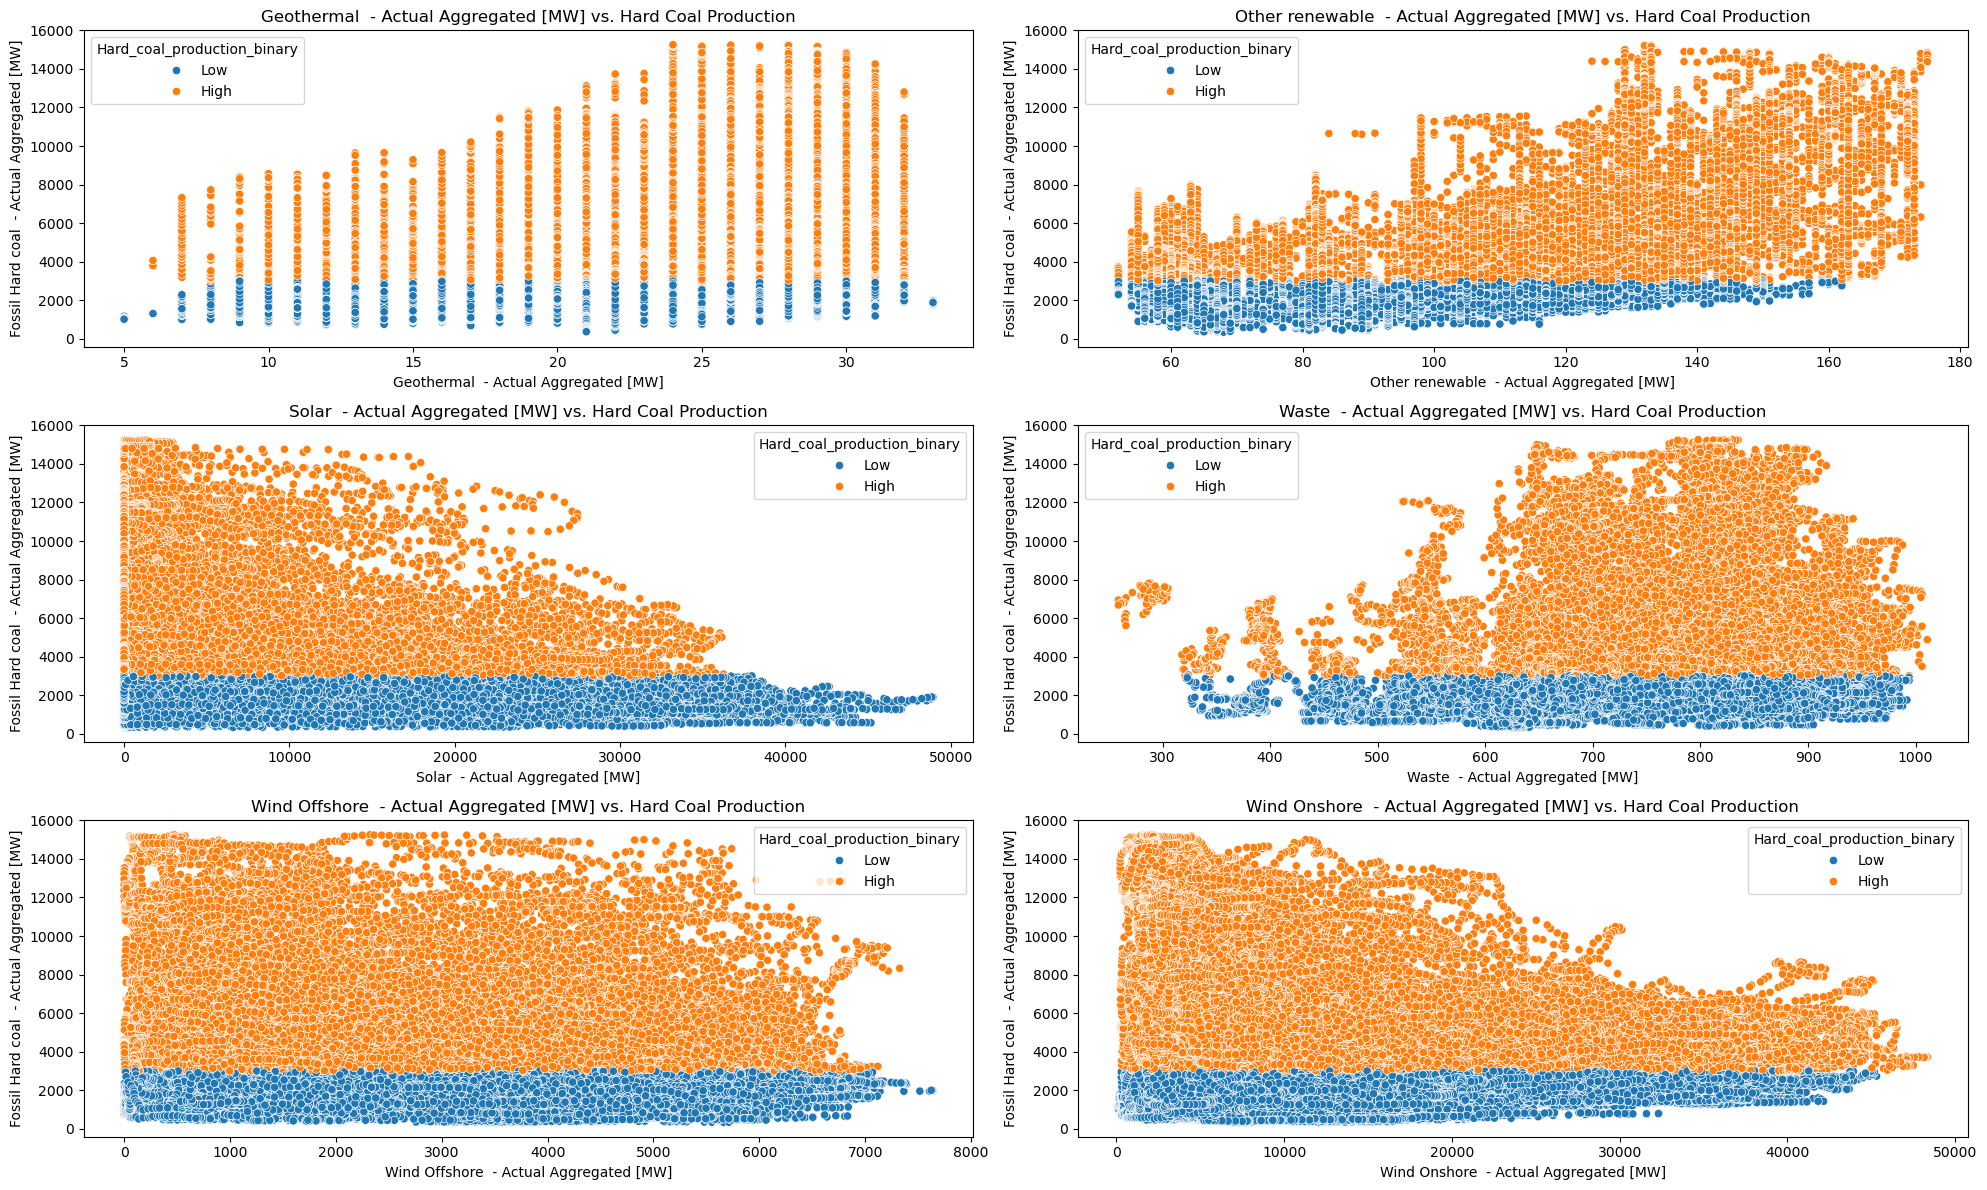

In [8]:
# Scatter plots for each feature vs. hard coal production
features_to_plot = [
    'Geothermal  - Actual Aggregated [MW]',
    'Other renewable  - Actual Aggregated [MW]',
    'Solar  - Actual Aggregated [MW]',
    'Waste  - Actual Aggregated [MW]',
    'Wind Offshore  - Actual Aggregated [MW]',
    'Wind Onshore  - Actual Aggregated [MW]'
]

plt.figure(figsize=(20, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=feature, y='Fossil Hard coal  - Actual Aggregated [MW]', hue='Hard_coal_production_binary', data=df)
    plt.title(f'{feature} vs. Hard Coal Production')
plt.tight_layout()
plt.show()



#### Description:

##### Geothermal - Actual Aggregated [MW] vs. Hard Coal Production:
        
    As geothermal production increases from 5 MW to 30 MW, the hard coal production shows two distinct clusters.
         
         - Low Geothermal (5-10 MW): There is a mix of low and high hard coal production.
         - High Geothermal (>10 MW): High hard coal production dominates, indicating that increased geothermal production
         is associated with higher hard coal production.
         
        
##### Other Renewable - Actual Aggregated [MW] vs. Hard Coal Production:
        
    There is a mix of low and high hard coal production across the range of other renewable energy production (60-180
    MW).
       
           - General Trend: As the production of other renewables increases, there seems to be a tendency for higher hard
           coal production.
           - Observation: Most data points are concentrated at higher hard coal production levels regardless of the
           renewable energy output
           

##### Solar - Actual Aggregated [MW] vs. Hard Coal Production:
        
    As solar production increases from 0 to 50,000 MW, hard coal production predominantly remains high, but there is
           a wide spread of both low and high hard coal production.
           
               -General Trend: Higher solar production correlates with a broader range of hard coal production, but
               predominantly higher coal production.
               
    
##### Waste - Actual Aggregated [MW] vs. Hard Coal Production:
        
    The production from waste shows a clustering of low hard coal production at lower waste production levels (200-
    500MW), and a mix of high and low hard coal production at higher waste production levels (500-1000 MW).
        
             -General Trend: Higher waste production tends to be associated with higher hard coal production.
    
    
##### Wind Offshore - Actual Aggregated [MW] vs. Hard Coal Production:
    
    As wind offshore production increases from 0 to 8000 MW, hard coal production predominantly remains high, similar
    to solar.
        
            -General Trend: Higher wind offshore production correlates with a mix of low and high hard coal production, but
            with a significant number of high coal production points.
    
##### Wind Onshore - Actual Aggregated [MW] vs. Hard Coal Production:
    
    As wind onshore production increases from 0 to 50,000 MW, hard coal production shows a wide spread with a significant
    number of high coal production points.
    
        -General Trend: Higher wind onshore production correlates with higher hard coal production, but there is a
        significant spread indicating variability.
    
##### Conclusion:

    Higher production of renewable energy sources such as geothermal, solar, wind offshore, and wind onshore often
    correlates with high hard coal production. This could indicate that renewable energy sources are supplementing rather
    than replacing hard coal production.
    

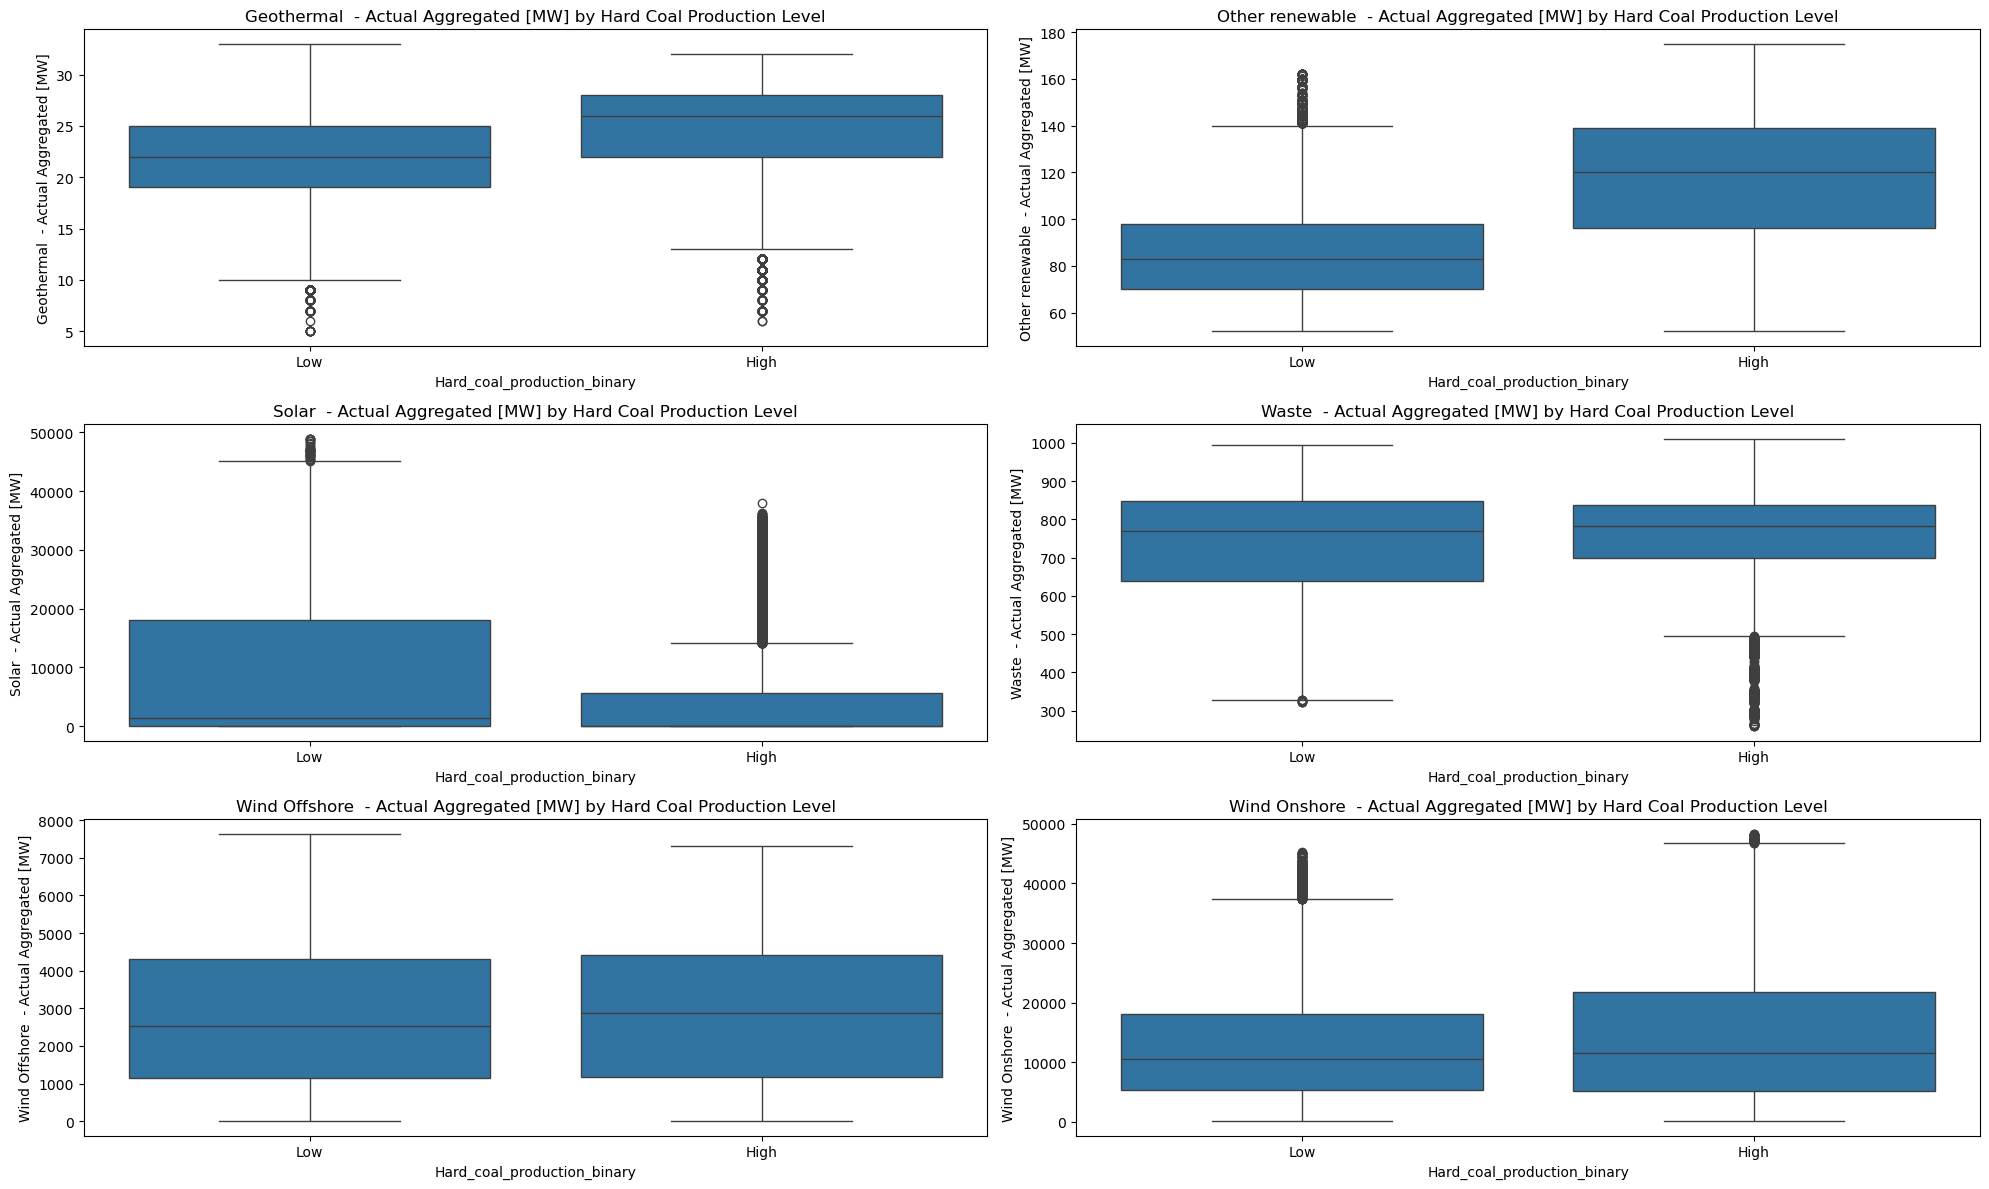

In [9]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Hard_coal_production_binary', y=feature, data=df)
    plt.title(f'{feature} by Hard Coal Production Level')
plt.tight_layout()
plt.show()


#### Description:

These box plots shows a clearer picture of the distribution and central tendency of renewable energy production
levels in relation to hard coal production, highlighting distinct patterns and potential relationships between them.

    - Positive Correlation: Higher hard coal production is generally associated with higher production of geothermal, other
    renewables, and waste.
    
    - Inverse Relationship: Higher solar, wind offshore, and wind onshore production tend to be associated with lower hard
    coal production, indicating a potential substitution effect.
    
    - Variability: Higher production levels (both low and high hard coal production) are associated with greater
    variability in renewable energy production, as indicated by the presence of outliers and wider interquartile ranges.
    

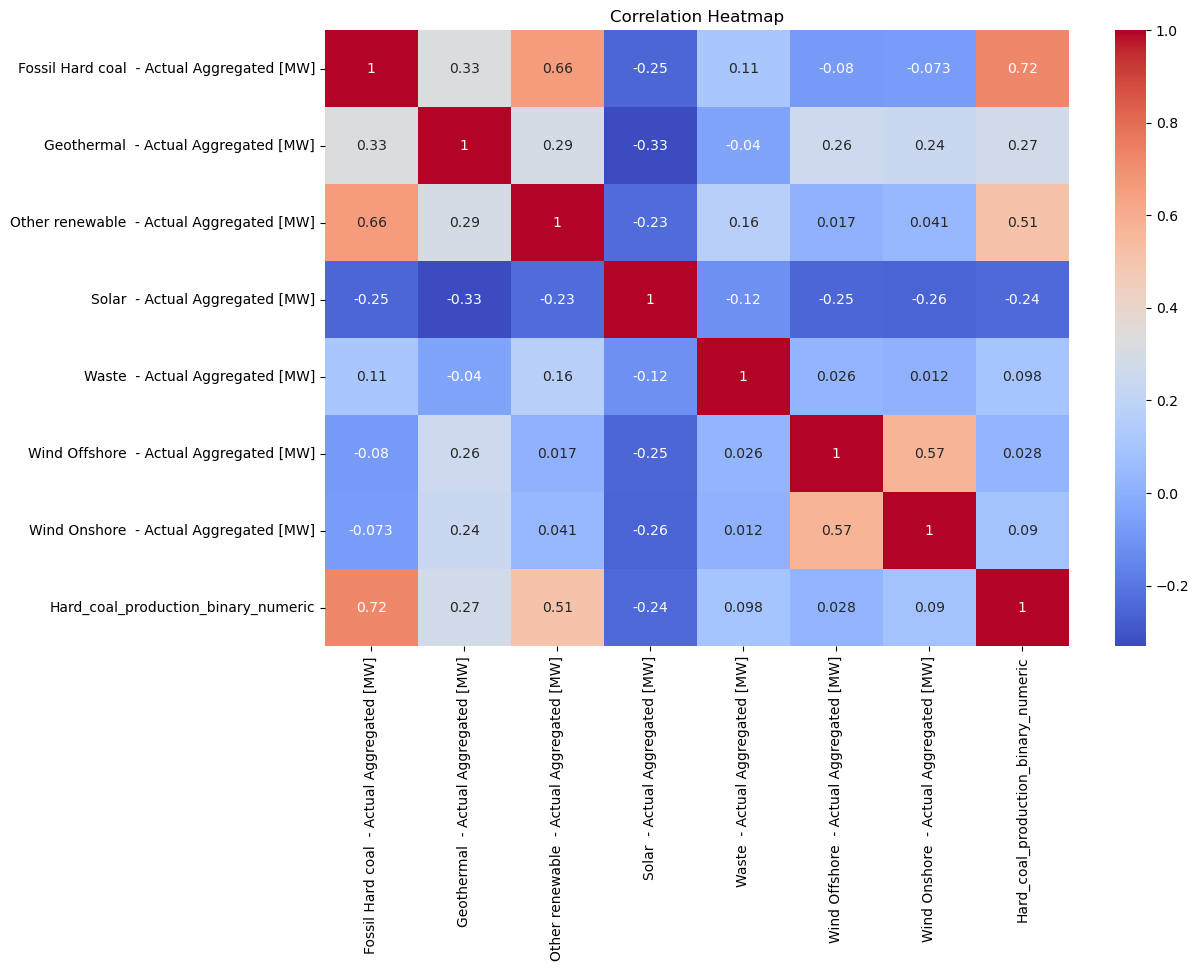

In [10]:
# Ensure that only numeric columns are included in the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



#### Summary of key relationship: 

higher solar energy production might be associated with lower fossil hard coal production, while higher geothermal and other renewable energy production might accompany higher hard coal production.


Positive Correlations:

    -Fossil hard coal is moderately positively correlated with other renewable energy production.
    -Geothermal has a weak positive correlation with fossil hard coal and wind energy production.
    -Other renewable sources show a moderate positive correlation with fossil hard coal.
    -Wind offshore and wind onshore are moderately positively correlated with each other.
    -Hard coal binary production is strongly correlated with fossil hard coal production and moderately with other
    renewables
    
Negative Correlations:

    -Solar energy shows weak negative correlations with fossil hard coal, geothermal, other renewable sources, wind
    offshore, and wind onshore, indicating potential substitution effects.



### 1.3 Include two heatmaps (x: day of year, y: time of day) of your target variable:

- Continuous variable
- Binary variable

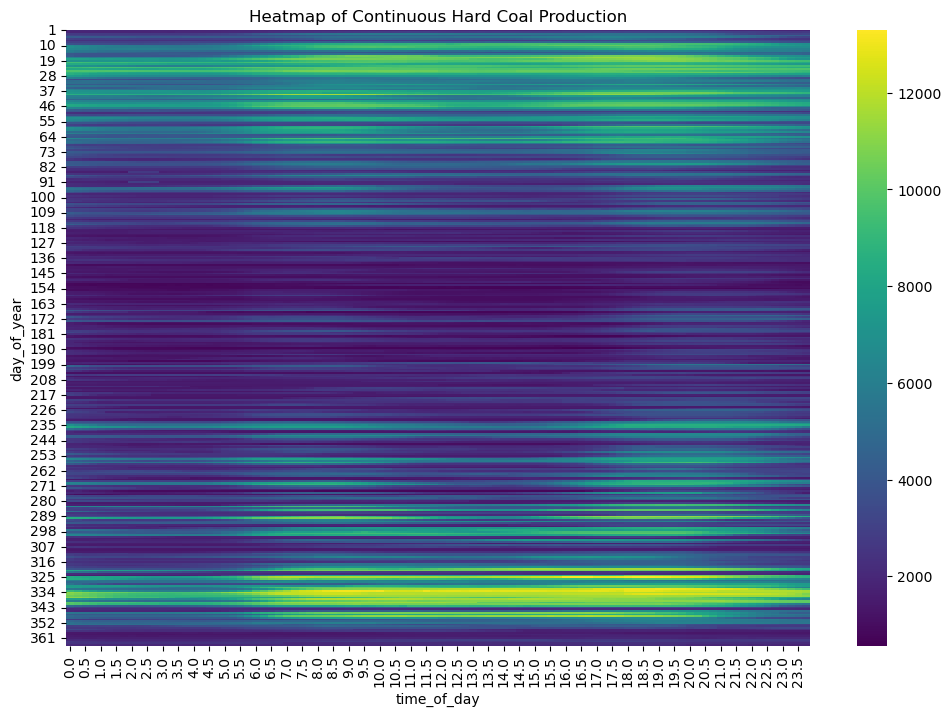

In [11]:
# Add day_of_year and time_of_day columns
df['day_of_year'] = df.index.dayofyear
df['time_of_day'] = df.index.hour + df.index.minute / 60

# Heatmap of continuous target variable over time
heatmap_data_cont = df.pivot_table(index='day_of_year', columns='time_of_day', values='Fossil Hard coal  - Actual Aggregated [MW]')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_cont, cmap='viridis')
plt.title('Heatmap of Continuous Hard Coal Production')
plt.show()


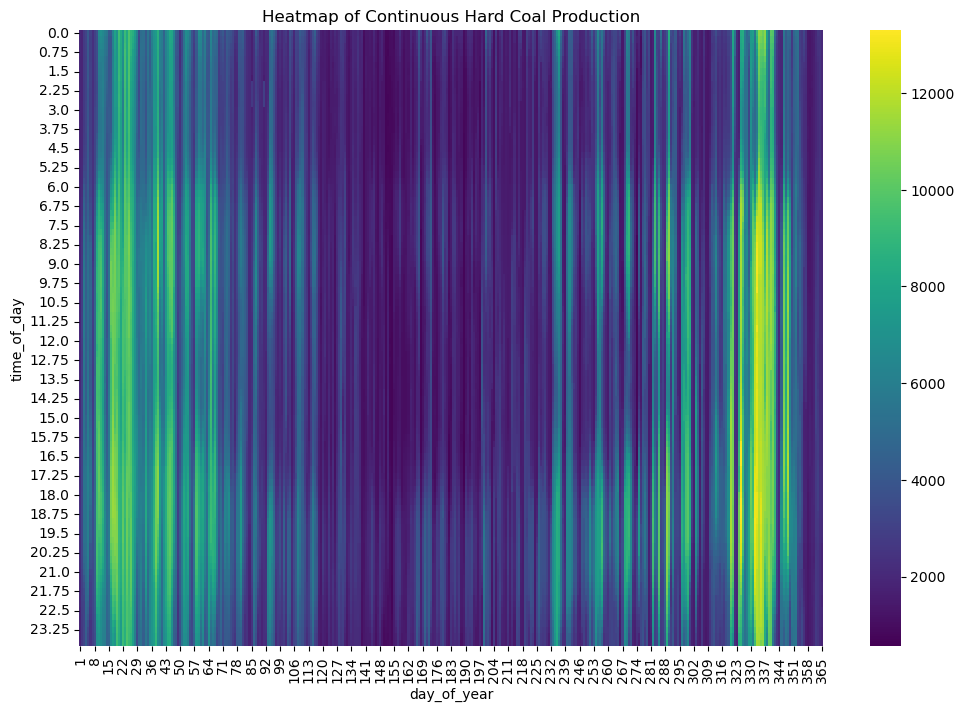

In [12]:
# Add day_of_year and time_of_day columns
df['day_of_year'] = df.index.dayofyear
df['time_of_day'] = df.index.hour + df.index.minute / 60

# Heatmap of continuous target variable over time
heatmap_data_cont = df.pivot_table(index='time_of_day', columns='day_of_year', values='Fossil Hard coal  - Actual Aggregated [MW]')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_cont, cmap='viridis')
plt.title('Heatmap of Continuous Hard Coal Production')
plt.show()


#### Summary:

    - Heatmap: Shows the variation in hard coal production over the days of the year and times of the day.
    
    - Day of Year: Seasonal variations are evident, with higher production during certain times of the year.
    
    - Time of Day: Consistent production levels throughout the day with some variations.


#### Conclusion:

There are clear seasonal patterns in hard coal production, likely influenced by weather and demand.
Time of day shows less variation, suggesting that production is relatively stable throughout the day.

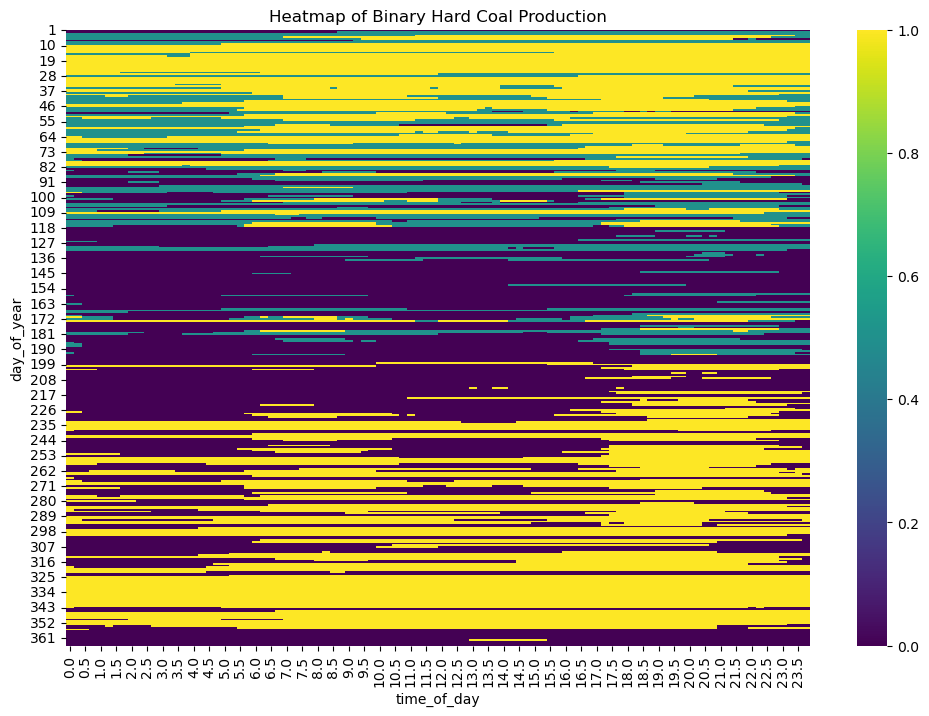

In [13]:
# Heatmap of binary target variable over time
heatmap_data_bin = df.pivot_table(index='day_of_year', columns='time_of_day', values='Hard_coal_production_binary_numeric')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_bin, cmap='viridis')
plt.title('Heatmap of Binary Hard Coal Production')
plt.show()

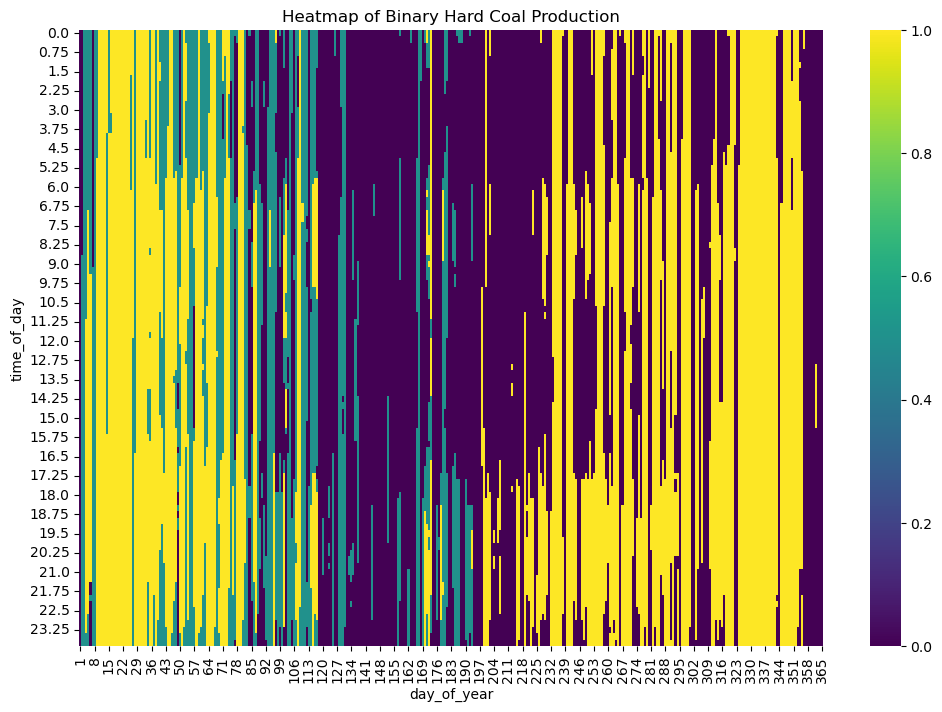

In [14]:
# Heatmap of binary target variable over time
heatmap_data_bin = df.pivot_table(index='time_of_day', columns='day_of_year', values='Hard_coal_production_binary_numeric')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_bin, cmap='viridis')
plt.title('Heatmap of Binary Hard Coal Production')
plt.show()

#### Summary:

    - Heatmap: Shows the distribution of "High" and "Low" production levels over the days of the year and times of the day.
    
    - Day of Year: Similar seasonal patterns as seen in the continuous heatmap, with distinct periods of high and low 
    production.
    
    - Time of Day: Variations are less pronounced compared to the continuous heatmap.


#### Conclusion:

Binary classification highlights periods with consistently high or low production, aligning with the continuous heatmap.
Seasonal variations are significant, suggesting that external factors such as weather and policy changes influence production levels.

## Task 2: Logistic Regression and k-Nearest Neighbors (kNN)

#### Data prepration : 

In [15]:
# Select features and target variable
features = df.drop(columns=[
    'Fossil Hard coal  - Actual Aggregated [MW]',
    'Hard_coal_production_binary',
    'Hard_coal_production_binary_numeric',
    'day_of_year',
    'time_of_day'
])
target = df['Hard_coal_production_binary_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features[features.index.year == 2023], target[target.index.year == 2023], test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train

Geothermal  - Actual Aggregated [MW]  \
Date                                                        
2023-09-13 08:00:00                                  18.0   
2023-05-12 06:00:00                                  28.0   
2023-08-26 18:00:00                                   9.0   
2023-07-10 23:00:00                                  13.0   
2023-05-25 18:45:00                                  19.0   
...                                                   ...   
2023-06-25 12:30:00                                  13.0   
2023-03-07 06:15:00                                  29.0   
2023-04-28 13:00:00                                  23.0   
2023-01-09 23:00:00                                  27.0   
2023-06-14 12:45:00                                  18.0   

                     Other renewable  - Actual Aggregated [MW]  \
Date                                                             
2023-09-13 08:00:00                                      114.0   
2023-05-12 06:00:00                                      110.0   
2023-08-26 18:00:00                                       87.0   
2023-07-10 23:00:00                                       83.0   
2023-05-25 18:45:00                                      103.0   
...                                                        ...   
2023-06-25 12:30:00                                       81.0   
2023-03-07 06:15:00                                      163.0   
2023-04-28 13:00:00                                      129.0   
2023-01-09 23:00:00                                      124.0   
2023-06-14 12:45:00                                       81.0   

                     Solar  - Actual Aggregated [MW]  \
Date                                                   
2023-09-13 08:00:00                           2987.0   
2023-05-12 06:00:00                            463.0   
2023-08-26 18:00:00                           6698.0   
2023-07-10 23:00:00                              3.0   
2023-05-25 18:45:00                           9286.0   
...                                              ...   
2023-06-25 12:30:00                          38104.0   
2023-03-07 06:15:00                              3.0   
2023-04-28 13:00:00                          14914.0   
2023-01-09 23:00:00                              1.0   
2023-06-14 12:45:00                          35398.0   

                     Waste  - Actual Aggregated [MW]  \
Date                                                   
2023-09-13 08:00:00                            758.0   
2023-05-12 06:00:00                            730.0   
2023-08-26 18:00:00                            972.0   
2023-07-10 23:00:00                            664.0   
2023-05-25 18:45:00                            845.0   
...                                              ...   
2023-06-25 12:30:00                            601.0   
2023-03-07 06:15:00                            485.0   
2023-04-28 13:00:00                            665.0   
2023-01-09 23:00:00                            815.0   
2023-06-14 12:45:00                            578.0   

                     Wind Offshore  - Actual Aggregated [MW]  \
Date                                                           
2023-09-13 08:00:00                                   3130.0   
2023-05-12 06:00:00                                   2216.0   
2023-08-26 18:00:00                                   1323.0   
2023-07-10 23:00:00                                    535.0   
2023-05-25 18:45:00                                   3827.0   
...                                                      ...   
2023-06-25 12:30:00                                    259.0   
2023-03-07 06:15:00                                   3078.0   
2023-04-28 13:00:00                                   3090.0   
2023-01-09 23:00:00                                   4229.0   
2023-06-14 12:45:00                                    711.0   

                     Wind Onshore  - Actual Aggregated [MW]  
Date           

In [17]:
X_train_scaled

array([[-0.68241066,  0.10863202, -0.34396848, -0.0837923 ,  0.23765752,
        -0.37369681],
       [ 1.05752272, -0.04044918, -0.59866496, -0.31531416, -0.26215421,
        -0.56082787],
       [-2.2483507 , -0.89766608,  0.03050799,  1.68569628, -0.7504823 ,
        -0.70736486],
       ...,
       [ 0.18755603,  0.66768652,  0.85958336, -0.85277565,  0.21578392,
        -0.60066317],
       [ 0.88352938,  0.48133502, -0.64528531,  0.38752008,  0.83863465,
         0.31773018],
       [-0.68241066, -1.12128788,  2.92662083, -1.57214717, -1.08514836,
        -0.38991546]])

### 2.1 Implement and train a logistic regression model and identify the optimum parameters

#### Logistic Regression:

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Define the logistic regression model
log_reg = LogisticRegression(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear','newton-cg']
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_log_reg = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
grid_search_log_reg.fit(X_train_scaled, y_train)

# Best parameters
best_params_log_reg = grid_search_log_reg.best_params_
print("Best parameters for Logistic Regression:", best_params_log_reg)

# Evaluate the model on the test set
y_pred_log_reg = grid_search_log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_log_reg))

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      4823
           1       0.78      0.77      0.78      5691

    accuracy                           0.76     10514
   macro avg       0.76      0.76      0.76     10514
weighted avg       0.76      0.76      0.76     10514



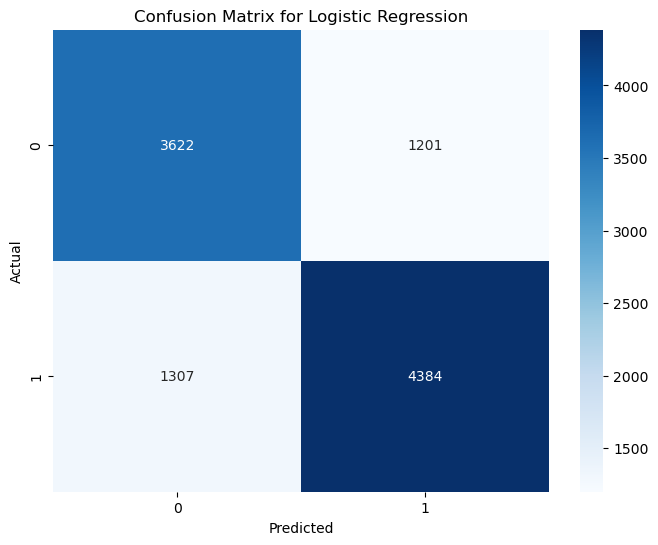

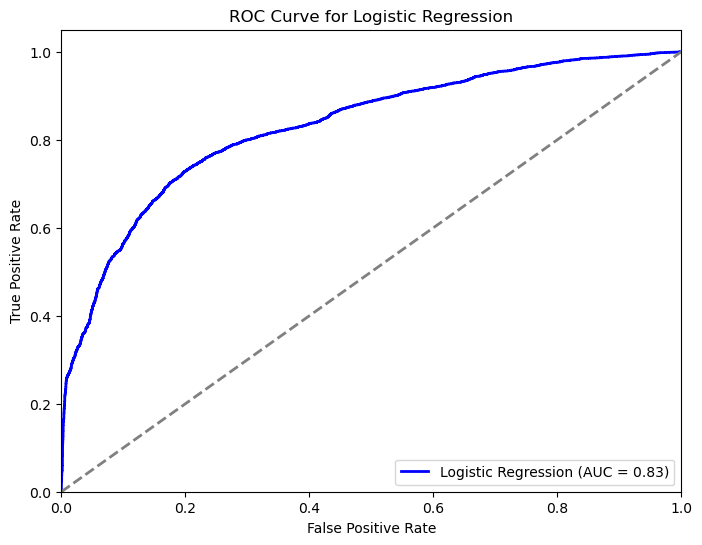

In [19]:
# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_pred_prob_log_reg = grid_search_log_reg.predict_proba(X_test_scaled)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_prob_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### 2.2 Implement and train a kNN model
- Identify the optimum hyperparameters

- Make a meaningful plot showing train and test scores

### 2.2.1 Identify the optimum hyperparameters

#### k-Nearest Neighbors (kNN):

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Define the kNN model
knn = KNeighborsClassifier()

# Define hyperparameters for tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring='roc_auc')
grid_search_knn.fit(X_train_scaled, y_train)

# Best parameters
best_params_knn = grid_search_knn.best_params_
print("Best parameters for kNN:", best_params_knn)

# Evaluate the model on the test set
y_pred_knn = grid_search_knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))



Best parameters for kNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4823
           1       0.98      0.97      0.97      5691

    accuracy                           0.97     10514
   macro avg       0.97      0.97      0.97     10514
weighted avg       0.97      0.97      0.97     10514



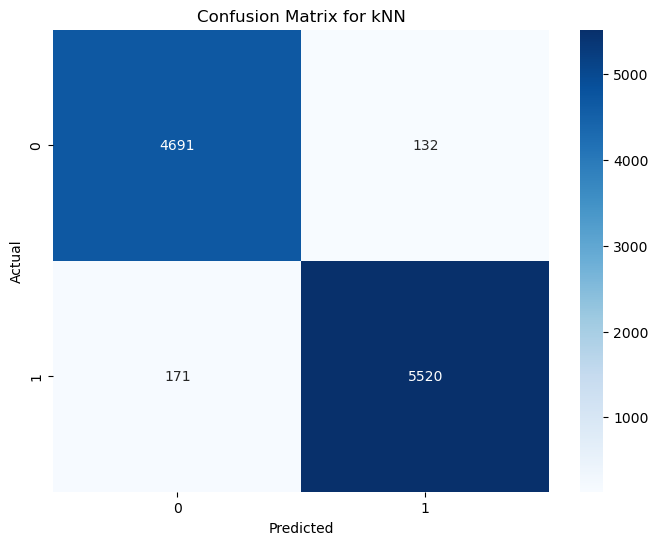

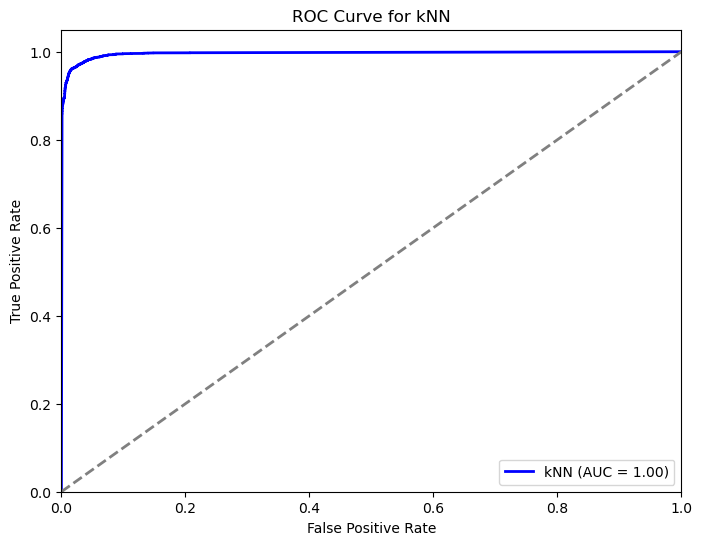

In [21]:
# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for kNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_pred_prob_knn = grid_search_knn.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='kNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for kNN')
plt.legend(loc="lower right")
plt.show()

### 2.2.2  plot showing train and test scores

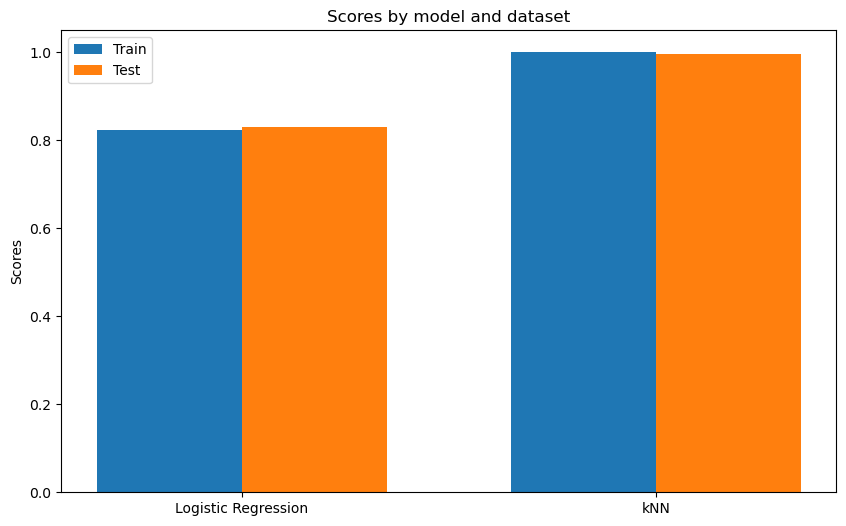

In [22]:
#credits: ClaudeAI
from sklearn.model_selection import cross_val_score

def plot_scores(estimators, X_train, X_test, y_train, y_test):
    models = list(estimators.keys())
    train_scores = []
    test_scores = []

    for name, model in estimators.items():
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
    rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

    ax.set_ylabel('Scores')
    ax.set_title('Scores by model and dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()

estimators = {
    'Logistic Regression': grid_search_log_reg,
    'kNN': grid_search_knn
}

plot_scores(estimators, X_train_scaled, X_test_scaled, y_train, y_test)

### 2.3 Evaluate and compare kNN and logistic regression models

- Compare all relevant scores for the comparison that were disucssed during class

- Visualize confusion matrix and roc plot

- Explain which scoring value is the default for your case? Why?

### 2.3.1 Compare all relevant scores for the comparison that were disucssed during class

In [23]:
#Credits: Prof. Dr. Lämmle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score,matthews_corrcoef

accuracy = accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn, average='weighted')
precision = precision_score(y_test, y_pred_knn, average='weighted',zero_division=False)
f1s = f1_score(y_test, y_pred_knn, average='weighted')
ROC_AUC = roc_auc_score(y_test, y_pred_knn, average='weighted')
MCC = matthews_corrcoef(y_test, y_pred_knn)


print("KNN Results:")
print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("ROC_AUC: "+ "{:.2%}".format(ROC_AUC))
print("MCC: "+ "{:.2%}".format(MCC))

KNN Results:
Accuracy: 97.12%
Recall: 97.12%
Precision: 97.12%
F1-Score: 97.12%
ROC_AUC: 97.13%
MCC: 94.20%


In [24]:
accuracy = accuracy_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg, average='weighted')
precision = precision_score(y_test, y_pred_log_reg, average='weighted',zero_division=False)
f1s = f1_score(y_test, y_pred_log_reg, average='weighted')
ROC_AUC = roc_auc_score(y_test, y_pred_log_reg, average='weighted')
MCC = matthews_corrcoef(y_test, y_pred_log_reg)


print("Logistic Regression Results:")
print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("ROC_AUC: "+ "{:.2%}".format(ROC_AUC))
print("MCC: "+ "{:.2%}".format(MCC))

Logistic Regression Results:
Accuracy: 76.15%
Recall: 76.15%
Precision: 76.20%
F1-Score: 76.16%
ROC_AUC: 76.07%
MCC: 52.06%


### 2.3.2 Visualize roc plot

#### Comparison and Evaluation :

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      4823
           1       0.78      0.77      0.78      5691

    accuracy                           0.76     10514
   macro avg       0.76      0.76      0.76     10514
weighted avg       0.76      0.76      0.76     10514

Logistic Regression AUC: 0.8296992392038194
kNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4823
           1       0.98      0.97      0.97      5691

    accuracy                           0.97     10514
   macro avg       0.97      0.97      0.97     10514
weighted avg       0.97      0.97      0.97     10514

kNN AUC: 0.9957722129870806


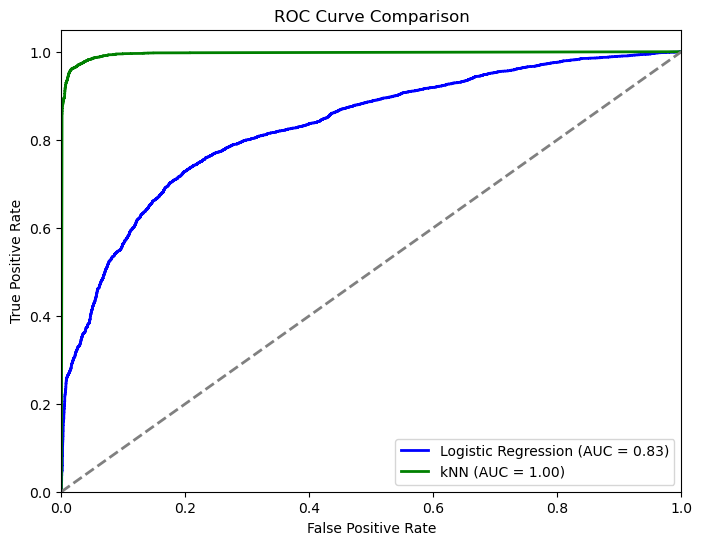

In [25]:
# Logistic Regression Metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression AUC:", roc_auc_log_reg)

# kNN Metrics
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("kNN AUC:", roc_auc_knn)

# Visual Comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_log_reg)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='kNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


### 2.3.3 Explain which scoring value is the default for your case? Why?

In [26]:
#Credits: ClaudeAI
from collections import Counter
class_distribution = Counter(y_train)
print("Class distribution:", class_distribution)

Class distribution: Counter({1: 13176, 0: 11354})


#### Comment:  roc_auc as our scoring value as our 1 and 0 are imbalance.

#### Summary: 

##### Logistic Regression:

The logistic regression model performs well with an AUC of 0.83. However, it has a higher rate of misclassification (both false positives and false negatives) compared to the kNN model.


##### k-Nearest Neighbors (kNN):

The kNN model performs exceptionally well with an AUC of 0.99. It has a much lower rate of misclassification, making it a more reliable model for predicting "High" and "Low" hard coal production.


##### Comparison:

The kNN model is the superior model based on the evaluation metrics and visualizations.
It provides better accuracy and reliability in classifying the hard coal production levels.

Given the results, the kNN model should be favored for deployment and further analysis due to its superior performance.

## Task 3: Decision Tree

######  Train the Decision Tree Model:

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(features[features.index.year == 2023], target[target.index.year == 2023], test_size=0.3, random_state=42)



##### Hyperparameter Tuning

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 4, 8],
    'class_weight': [None, 'balanced']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='roc_auc'
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_tree = grid_search.best_estimator_


In [29]:
best_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=8, random_state=42)

##### Model Evaluation with Cross-Validation

In [30]:
from sklearn.model_selection import cross_val_score

# Evaluate the model with cross-validation
roc_auc_scores = cross_val_score(best_tree, X_train, y_train, cv=10, scoring='roc_auc')
roc_auc_CV = roc_auc_scores.mean()

print('CV roc_auc: {:.2f}'.format(roc_auc_CV))



CV roc_auc: 0.93


##### Evaluate on Test Data

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions on test data
y_pred_tree = best_tree.predict(X_test)

# Compute roc_auc
roc_auc_tree = roc_auc_score(y_test, y_pred_tree)
print("Test roc_auc: {:.2f}".format(roc_auc_tree))

# Print classification report
print(classification_report(y_test, y_pred_tree))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_tree)


Test roc_auc: 0.86
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      4823
           1       0.89      0.84      0.86      5691

    accuracy                           0.86     10514
   macro avg       0.85      0.86      0.85     10514
weighted avg       0.86      0.86      0.86     10514



##### Visualize Confusion Matrix

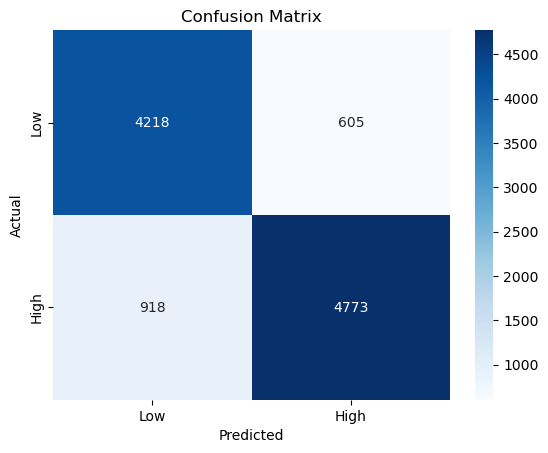

In [32]:
# Plot confusion matrix
sns.heatmap(
    pd.DataFrame(cnf_matrix, columns=['Low', 'High'], index=['Low', 'High']),
    annot=True,
    cmap="Blues",
    fmt='d'
)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


##### Visualize Decision Tree

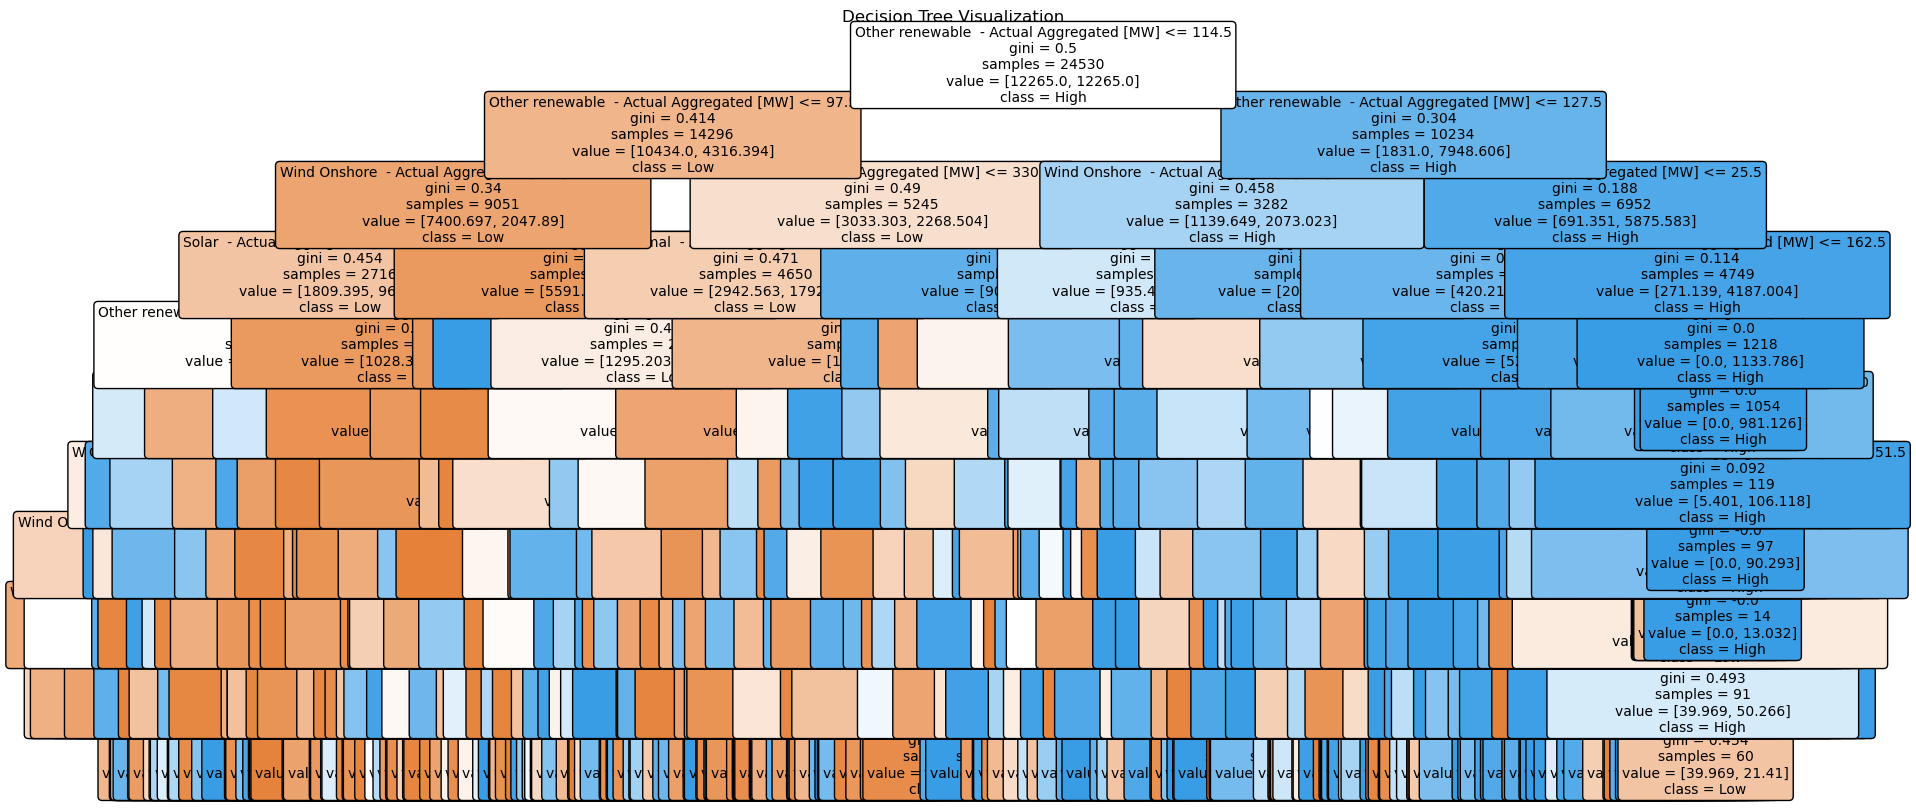

In [33]:
from sklearn.tree import plot_tree
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X_train.columns.tolist(),
    class_names=['Low', 'High'],
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Visualization')
plt.show()


##### Text Representation of the Tree

In [34]:
from sklearn.tree import export_text

# Print text representation of the tree
print(export_text(best_tree, feature_names=list(X_train.columns), show_weights=True))


|--- Other renewable  - Actual Aggregated [MW] <= 114.50
|   |--- Other renewable  - Actual Aggregated [MW] <= 97.50
|   |   |--- Wind Onshore  - Actual Aggregated [MW] <= 4391.00
|   |   |   |--- Solar  - Actual Aggregated [MW] <= 15907.50
|   |   |   |   |--- Other renewable  - Actual Aggregated [MW] <= 83.50
|   |   |   |   |   |--- Waste  - Actual Aggregated [MW] <= 859.50
|   |   |   |   |   |   |--- Waste  - Actual Aggregated [MW] <= 677.50
|   |   |   |   |   |   |   |--- Wind Onshore  - Actual Aggregated [MW] <= 2293.50
|   |   |   |   |   |   |   |   |--- Wind Offshore  - Actual Aggregated [MW] <= 477.00
|   |   |   |   |   |   |   |   |   |--- Waste  - Actual Aggregated [MW] <= 564.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [6.48, 2.79] class: 0
|   |   |   |   |   |   |   |   |   |--- Waste  - Actual Aggregated [MW] >  564.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [91.82, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Wind Offshore  - Actual

##### Visualize Feature Importance

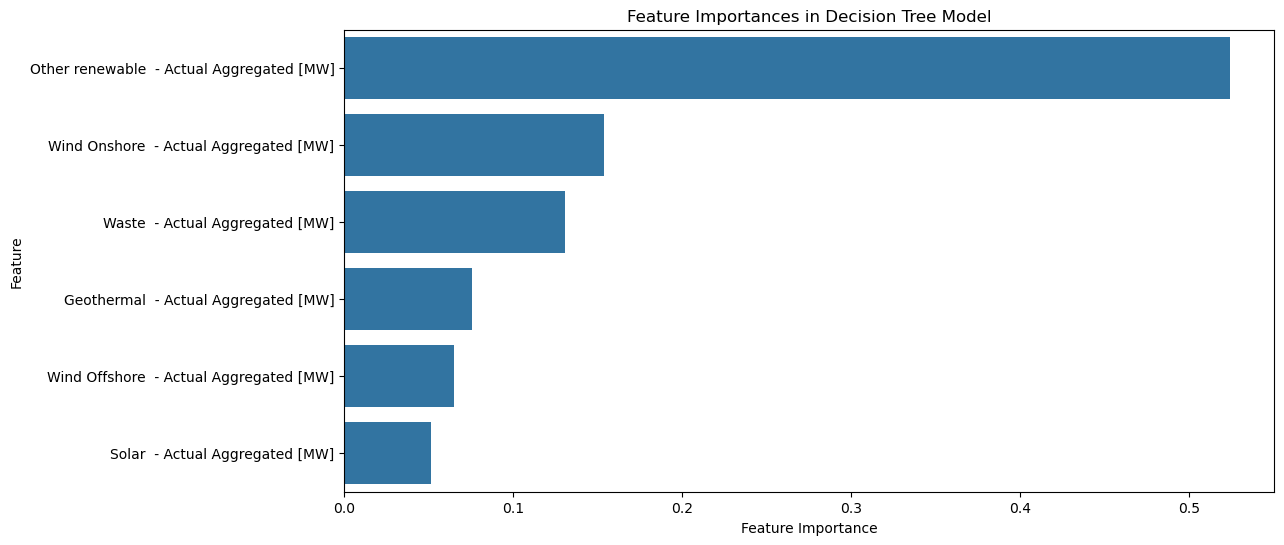

In [35]:
# Compute feature importances
feature_importances = best_tree.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importances[sorted_indices],
    y=np.array(X_train.columns)[sorted_indices]
)
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


## Task 4: Apply 5 different classification models and compare their score

Such as : 

- Linear and Quadratic Discriminant Analysis

- kNN

- Random Forests

- Boosting (AdaBoost, Linear Gradient Boosting, Stochastic Gradient Boosting, xgBoost)

- Bagging

- Support Vector Machines

- ANN


- Use CrossValidation and Hyperparameteroptimization for all models

- Select the best performing model. Explain why you chose this model

### 4.1 Classification models: 

1- Logistic Regression

2- KNN

3- Random Forests

4- Gradient Boosting

5- AdeBoost 

##### 1. Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      4823
           1       0.74      0.77      0.75      5691

    accuracy                           0.73     10514
   macro avg       0.73      0.73      0.73     10514
weighted avg       0.73      0.73      0.73     10514



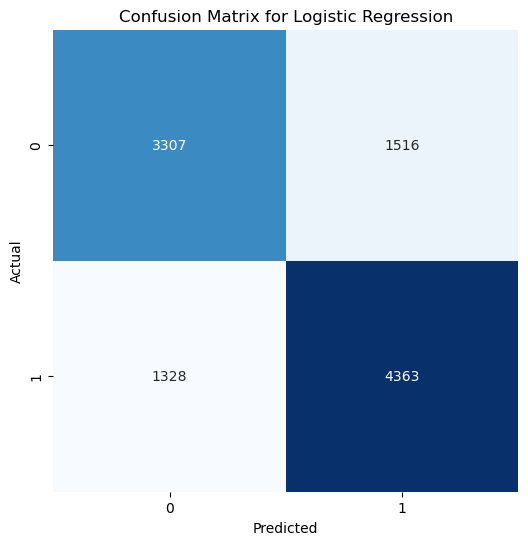

<Figure size 640x480 with 0 Axes>

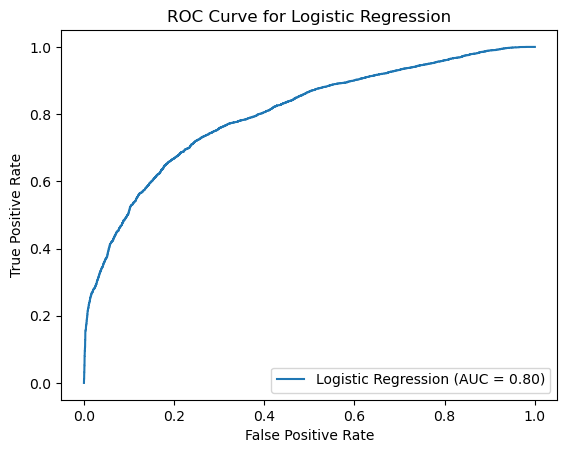

In [36]:

from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, RocCurveDisplay


# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


# Predict the labels for the test dataset
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
plt.figure()
RocCurveDisplay(fpr=fpr_log_reg, tpr=tpr_log_reg, roc_auc=roc_auc_log_reg, estimator_name="Logistic Regression").plot()
plt.title("ROC Curve for Logistic Regression")
plt.show()


##### 2. k-Nearest Neighbors (kNN)

kNN Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      4823
           1       0.72      0.76      0.74      5691

    accuracy                           0.71     10514
   macro avg       0.71      0.71      0.71     10514
weighted avg       0.71      0.71      0.71     10514



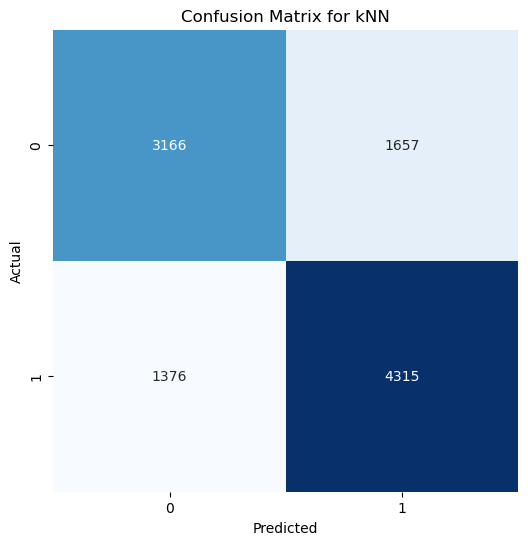

<Figure size 640x480 with 0 Axes>

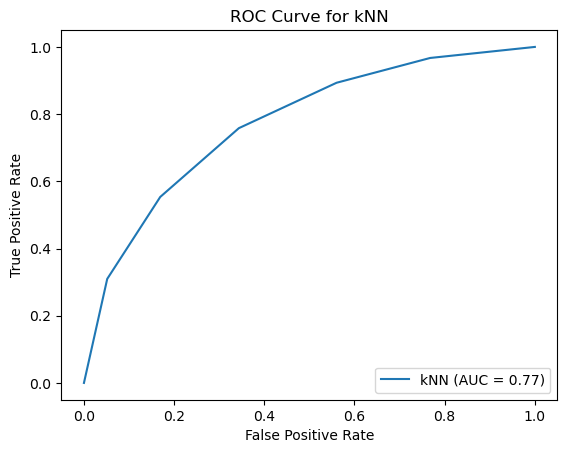

In [37]:
# Train the kNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the labels for the test dataset
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for kNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=roc_auc_knn, estimator_name="kNN").plot()
plt.title("ROC Curve for kNN")
plt.show()


##### 3. Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4823
           1       0.97      0.97      0.97      5691

    accuracy                           0.97     10514
   macro avg       0.97      0.97      0.97     10514
weighted avg       0.97      0.97      0.97     10514



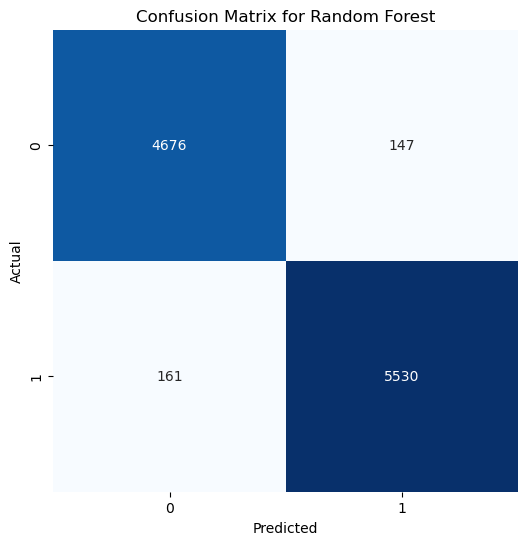

<Figure size 640x480 with 0 Axes>

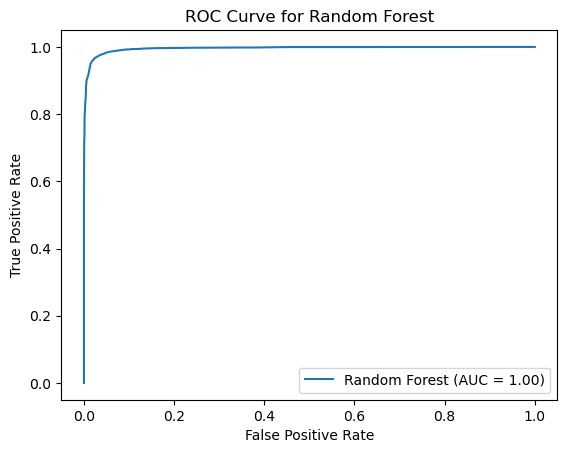

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# Predict the labels for the test dataset
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure()
RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, estimator_name="Random Forest").plot()
plt.title("ROC Curve for Random Forest")
plt.show()


##### 4. Gradient Boosting

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4823
           1       0.84      0.83      0.84      5691

    accuracy                           0.82     10514
   macro avg       0.82      0.82      0.82     10514
weighted avg       0.83      0.82      0.82     10514



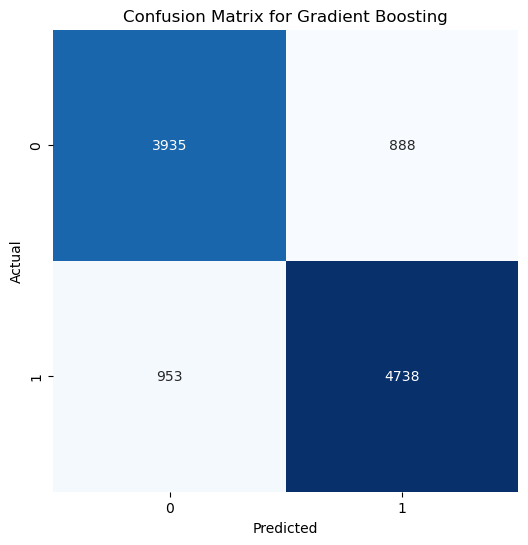

<Figure size 640x480 with 0 Axes>

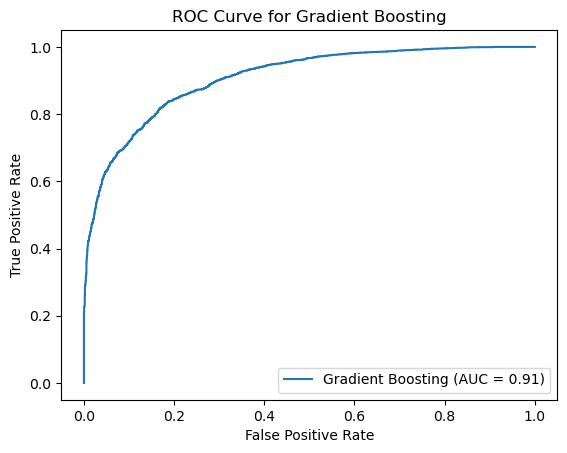

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# Predict the labels for the test dataset
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.figure()
RocCurveDisplay(fpr=fpr_gb, tpr=tpr_gb, roc_auc=roc_auc_gb, estimator_name="Gradient Boosting").plot()
plt.title("ROC Curve for Gradient Boosting")
plt.show()


##### 5. AdaBoost

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4823
           1       0.81      0.78      0.80      5691

    accuracy                           0.78     10514
   macro avg       0.78      0.79      0.78     10514
weighted avg       0.79      0.78      0.79     10514



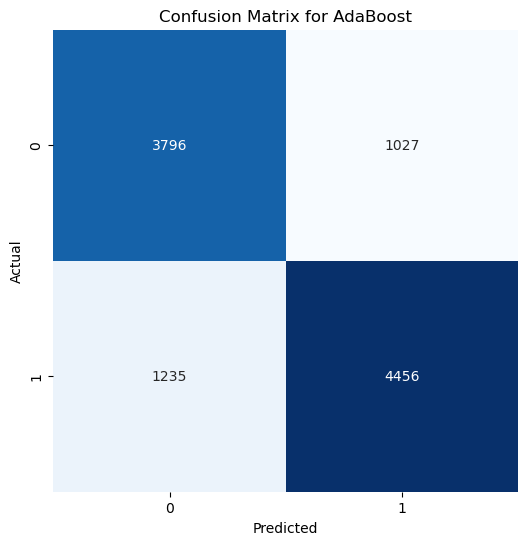

<Figure size 640x480 with 0 Axes>

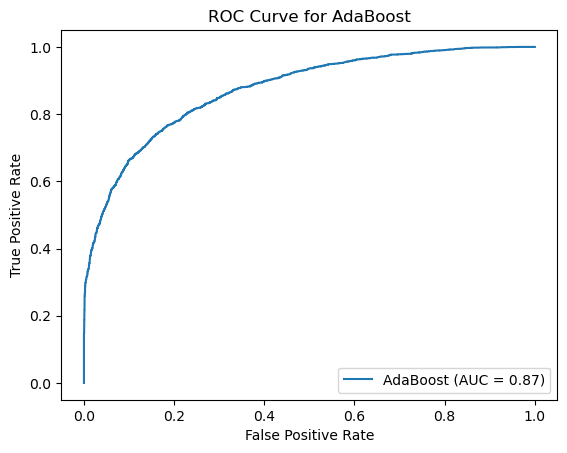

In [40]:
from sklearn.ensemble import AdaBoostClassifier


# Define and train the AdaBoost model with specified parameters
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=42)
ada.fit(X_train, y_train)

# Predict the labels for the test dataset
y_pred_ada = ada.predict(X_test)
y_pred_proba_ada = ada.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada))

# Confusion Matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_proba_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)
plt.figure()
RocCurveDisplay(fpr=fpr_ada, tpr=tpr_ada, roc_auc=roc_auc_ada, estimator_name="AdaBoost").plot()
plt.title("ROC Curve for AdaBoost")
plt.show()

### 4.2 CrossValidation and Hyper parameter optimization for all models


##### Comparing All Models


In [41]:

# Define the train_and_evaluate_model function
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Classification report for {model_name}:\n {classification_report(y_test, y_pred)}")
    print(f"ROC AUC for {model_name}: {roc_auc_score(y_test, y_pred_proba)}\n")
    
    return best_model

# 1. Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}
best_lr = train_and_evaluate_model(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, X_train, y_train, X_test, y_test, "Logistic Regression")

# 2. k-Nearest Neighbors (kNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
best_knn = train_and_evaluate_model(KNeighborsClassifier(), param_grid_knn, X_train, y_train, X_test, y_test, "kNN")

# 3. Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
best_rf = train_and_evaluate_model(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, X_train, y_train, X_test, y_test, "Random Forest")

# 4. Gradient Boost
param_grid_gb = {
    'max_depth': [None, 4, 6],
    'n_estimators': [10, 25, 100, 200],
    'random_state': [2]
}
best_gb = train_and_evaluate_model(GradientBoostingClassifier(), param_grid_gb, X_train, y_train, X_test, y_test, "Gradient Boost")

# 5. AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}
best_ada = train_and_evaluate_model(AdaBoostClassifier(random_state=42), param_grid_ada, X_train, y_train, X_test, y_test, "AdaBoost")


Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Classification report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      4823
           1       0.74      0.77      0.75      5691

    accuracy                           0.73     10514
   macro avg       0.73      0.73      0.73     10514
weighted avg       0.73      0.73      0.73     10514

ROC AUC for Logistic Regression: 0.8023862333348015

Best parameters for kNN: {'n_neighbors': 9, 'weights': 'distance'}
Classification report for kNN:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68      4823
           1       0.73      0.77      0.75      5691

    accuracy                           0.72     10514
   macro avg       0.72      0.71      0.71     10514
weighted avg       0.72      0.72      0.72     10514

ROC AUC for kNN: 0.7932041501630028

Best parameters for Random Forest: 

## 4.3 Select the best performing model. Explain why you chose this model


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      4823
           1       0.74      0.77      0.75      5691

    accuracy                           0.73     10514
   macro avg       0.73      0.73      0.73     10514
weighted avg       0.73      0.73      0.73     10514



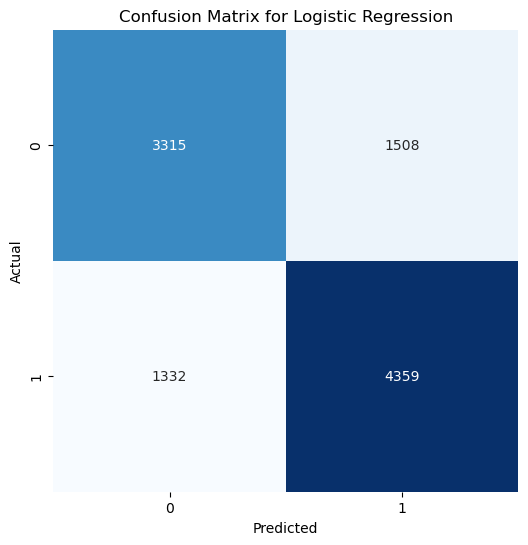


kNN Model Performance:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      4823
           1       0.73      0.77      0.75      5691

    accuracy                           0.72     10514
   macro avg       0.72      0.71      0.71     10514
weighted avg       0.72      0.72      0.72     10514



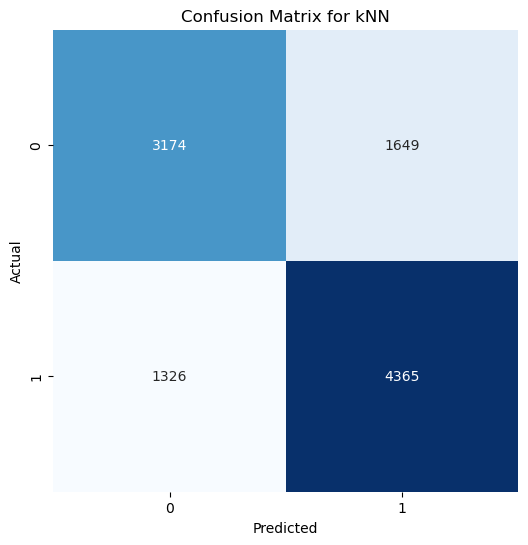


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4823
           1       0.98      0.97      0.97      5691

    accuracy                           0.97     10514
   macro avg       0.97      0.97      0.97     10514
weighted avg       0.97      0.97      0.97     10514



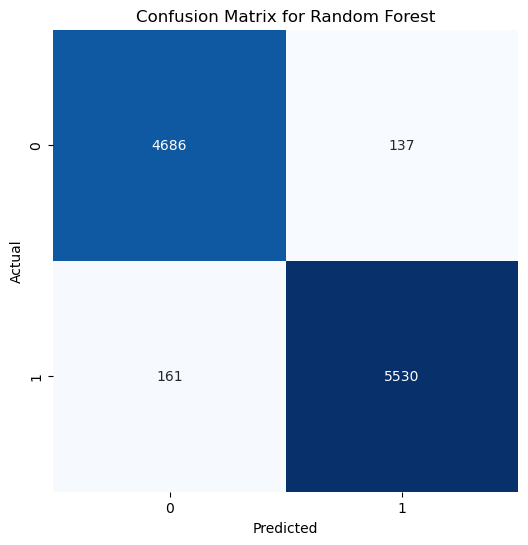


Gradient Boosting Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4823
           1       0.94      0.94      0.94      5691

    accuracy                           0.94     10514
   macro avg       0.94      0.94      0.94     10514
weighted avg       0.94      0.94      0.94     10514



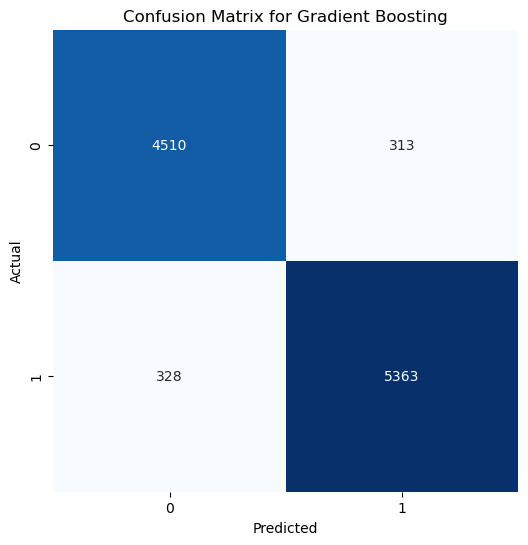


AdaBoost Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      4823
           1       0.82      0.80      0.81      5691

    accuracy                           0.79     10514
   macro avg       0.79      0.79      0.79     10514
weighted avg       0.79      0.79      0.79     10514



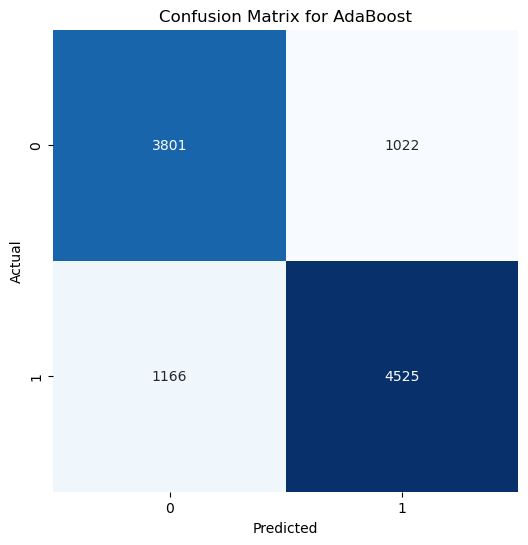

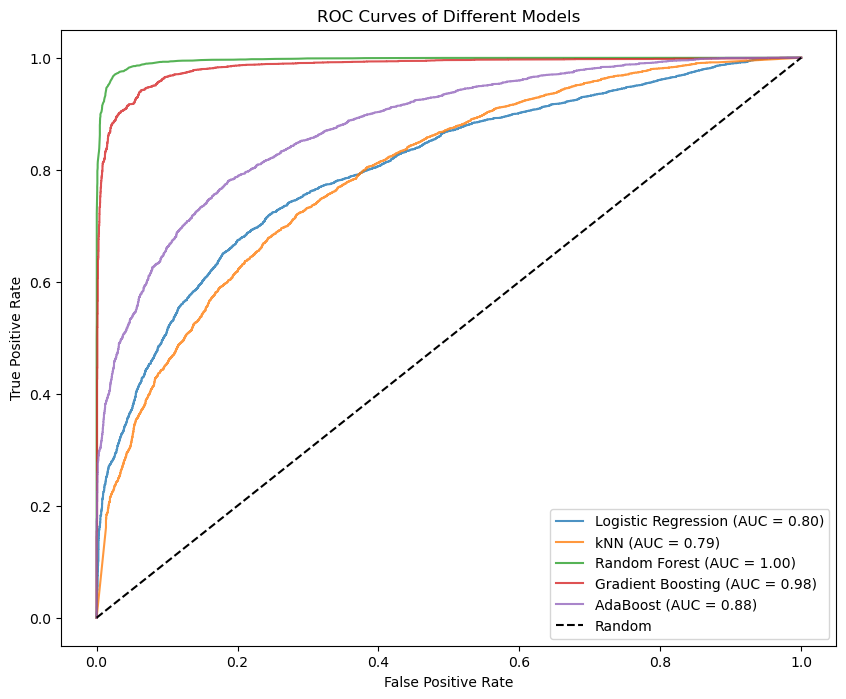

In [42]:
#credits: ChatGPT
# Function to plot the ROC curve for multiple models
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca(), alpha=0.8)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of Different Models')
    plt.legend(loc='lower right')
    plt.show()

# Comparing All Models
models = {
    "Logistic Regression": best_lr,
    "kNN": best_knn,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,
    "AdaBoost": best_ada
}

# Print classification reports and plot confusion matrices
for name, model in models.items():
    print(f"\n{name} Model Performance:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot ROC curves for all models
plot_roc_curves(models, X_test, y_test)

Comment: We are taking Random forest with parameters [{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}] as the roc_auc is 1 for this model.

## Task 5

- Train and fit the best performing model named „best_model“

- Deploy your model on 2024 data (which wasn‘t used for training!)

- Evaluate and visualize your predictions on the test data set

In [43]:
df[df.index.year== 2024]

Fossil Hard coal  - Actual Aggregated [MW]  \
Date                                                              
2024-01-01 00:00:00                                      1855.0   
2024-01-01 00:15:00                                      1863.0   
2024-01-01 00:30:00                                      1856.0   
2024-01-01 00:45:00                                      1869.0   
2024-01-01 01:00:00                                      1863.0   
...                                                         ...   
2024-07-11 22:45:00                                      3475.0   
2024-07-11 23:00:00                                      3450.0   
2024-07-11 23:15:00                                      3450.0   
2024-07-11 23:30:00                                      3399.0   
2024-07-11 23:45:00                                      3351.0   

                     Geothermal  - Actual Aggregated [MW]  \
Date                                                        
2024-01-01 00:00:00                                  29.0   
2024-01-01 00:15:00                                  29.0   
2024-01-01 00:30:00                                  29.0   
2024-01-01 00:45:00                                  29.0   
2024-01-01 01:00:00                                  29.0   
...                                                   ...   
2024-07-11 22:45:00                                  22.0   
2024-07-11 23:00:00                                  22.0   
2024-07-11 23:15:00                                  22.0   
2024-07-11 23:30:00                                  22.0   
2024-07-11 23:45:00                                  22.0   

                     Other renewable  - Actual Aggregated [MW]  \
Date                                                             
2024-01-01 00:00:00                                       72.0   
2024-01-01 00:15:00                                       72.0   
2024-01-01 00:30:00                                       72.0   
2024-01-01 00:45:00                                       72.0   
2024-01-01 01:00:00                                       72.0   
...                                                        ...   
2024-07-11 22:45:00                                       83.0   
2024-07-11 23:00:00                                       83.0   
2024-07-11 23:15:00                                       83.0   
2024-07-11 23:30:00                                       83.0   
2024-07-11 23:45:00                                       83.0   

                     Solar  - Actual Aggregated [MW]  \
Date                                                   
2024-01-01 00:00:00                              3.0   
2024-01-01 00:15:00                              3.0   
2024-01-01 00:30:00                              2.0   
2024-01-01 00:45:00                              2.0   
2024-01-01 01:00:00                              3.0   
...                                              ...   
2024-07-11 22:45:00                              0.0   
2024-07-11 23:00:00                              0.0   
2024-07-11 23:15:00                              0.0   
2024-07-11 23:30:00                              0.0   
2024-07-11 23:45:00                              0.0   

                     Waste  - Actual Aggregated [MW]  \
Date                                                   
2024-01-01 00:00:00                            587.0   
2024-01-01 00:15:00                            592.0   
2024-01-01 00:30:00                            586.0   
2024-01-01 00:45:00                            571.0   
2024-01-01 01:00:00                            570.0   
...                                              ...   
2024-07-11 22:45:00                            866.0   
2024-07-11 23:00:00                            859.0   
2024-07-11 23:15:00                            860.0   
2024-07-11 23:30:00                            862.0   
2024-07-11 23:45:00                            861.0   

                     Wind Offshore  - 

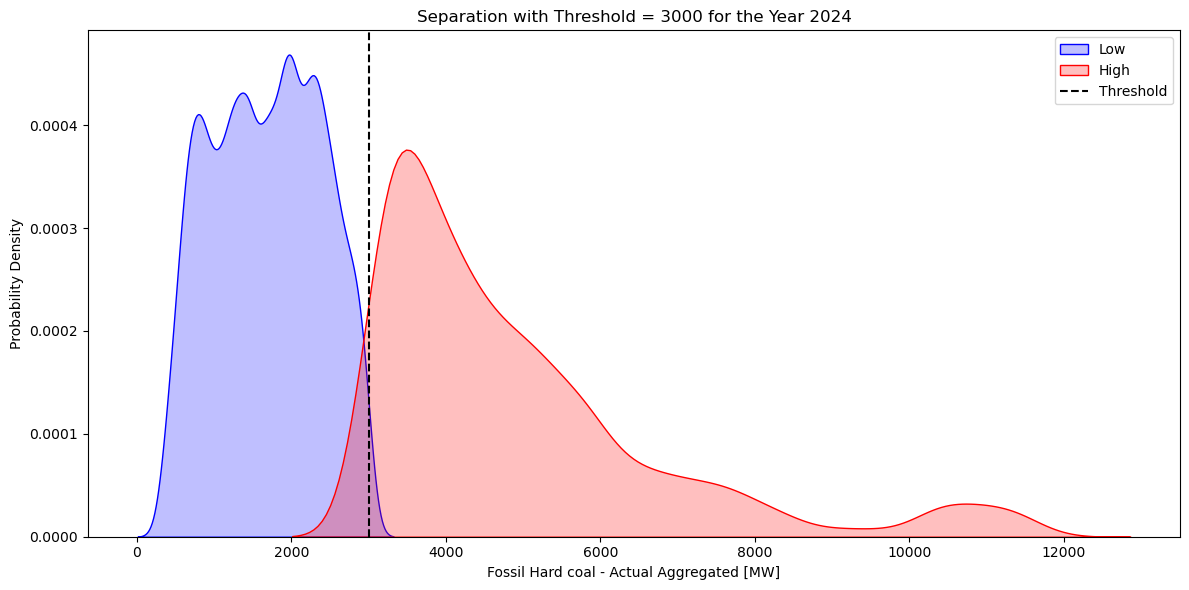

In [44]:

# Filter the DataFrame for the year 2024
df_2024 = df[df.index.year == 2024]

# Define the threshold value
threshold = 3000

# Plotting the separation of classes for the year 2024
plt.figure(figsize=(12, 6))

sns.kdeplot(df_2024[df_2024['Hard_coal_production_binary_numeric'] == 0]['Fossil Hard coal  - Actual Aggregated [MW]'], 
            color='blue', shade=True, label='Low')
sns.kdeplot(df_2024[df_2024['Hard_coal_production_binary_numeric'] == 1]['Fossil Hard coal  - Actual Aggregated [MW]'], 
            color='red', shade=True, label='High')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title(f'Separation with Threshold = {threshold} for the Year 2024')
plt.xlabel('Fossil Hard coal - Actual Aggregated [MW]')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

### 5.1 Train and fit the best performing model named „best_model“

In [45]:
# Instantiate rf
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split= 2, class_weight="balanced")

# Fit best model to the training set 
best_model=rf.fit(X_train, y_train)

###  5.2  Deploy the model on 2024 data (which wasn‘t used for training!)

In [46]:
# Predict test set labels
y_pred_bm = best_model.predict(features[features.index.year==2024])

### 5.3  Evaluate and visualize the predictions on the test data set

In [47]:
#Evaluate
print(f"ROC_AUC_Score: {roc_auc_score(target[target.index.year==2024], y_pred_bm)}")

ROC_AUC_Score: 0.6957009901154405


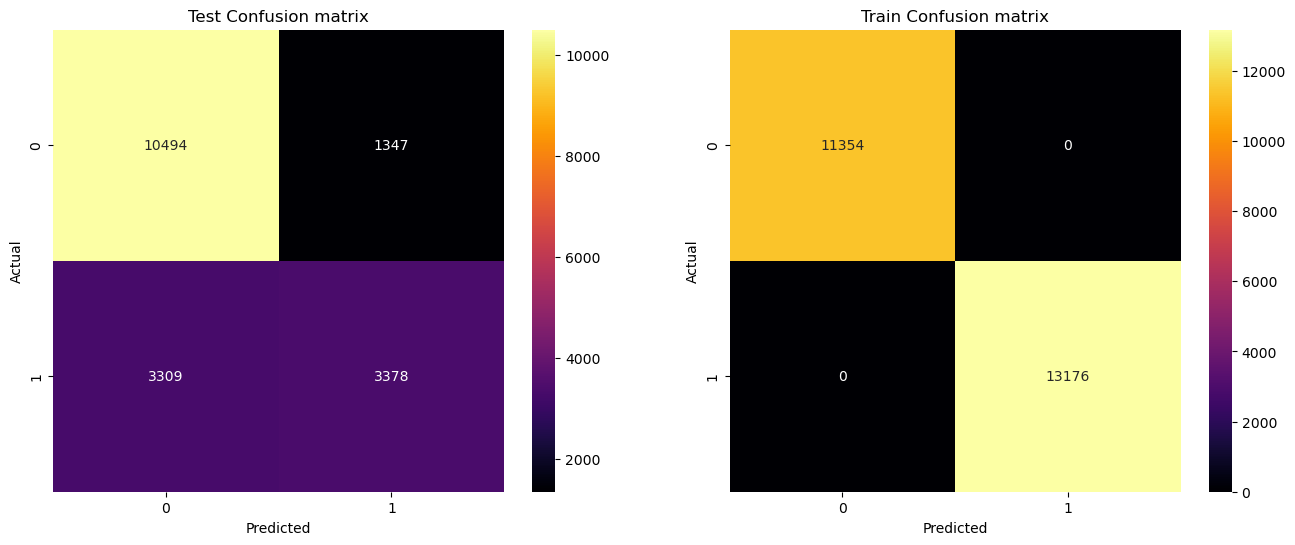

In [48]:
#Visualize
#CM for Test
cnf_matrix_test = confusion_matrix(target[target.index.year==2024], y_pred_bm)
df_cm = pd.DataFrame(cnf_matrix_test, columns=np.unique(target[target.index.year==2024]), index=np.unique(target[target.index.year==2024]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=True, fmt='.0f', ax=ax[0]) 
ax[0].set_title('Test Confusion matrix')

#CM for Train
cnf_matrix_train = confusion_matrix(y_train, best_model.predict(X_train))
df_cm = pd.DataFrame(cnf_matrix_train, columns=np.unique(y_train), index=np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=True, fmt='.0f', ax=ax[1]) 
ax[1].set_title('Train Confusion matrix')

plt.show()

In [49]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: ", grid_search.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation F1 score:  0.9613381678306816


In [51]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Assuming y_pred_bm contains the predictions for the year 2024
# Evaluate the model
roc_auc = roc_auc_score(target[target.index.year == 2024], y_pred_bm)
pr_auc = average_precision_score(target[target.index.year == 2024], y_pred_bm)
f1 = f1_score(target[target.index.year == 2024], y_pred_bm)

print(f"ROC_AUC_Score: {roc_auc}")
print(f"PR_AUC_Score: {pr_auc}")
print(f"F1_Score: {f1}")


ROC_AUC_Score: 0.6937844640984596
PR_AUC_Score: 0.5417795098033985
F1_Score: 0.5862871464375224


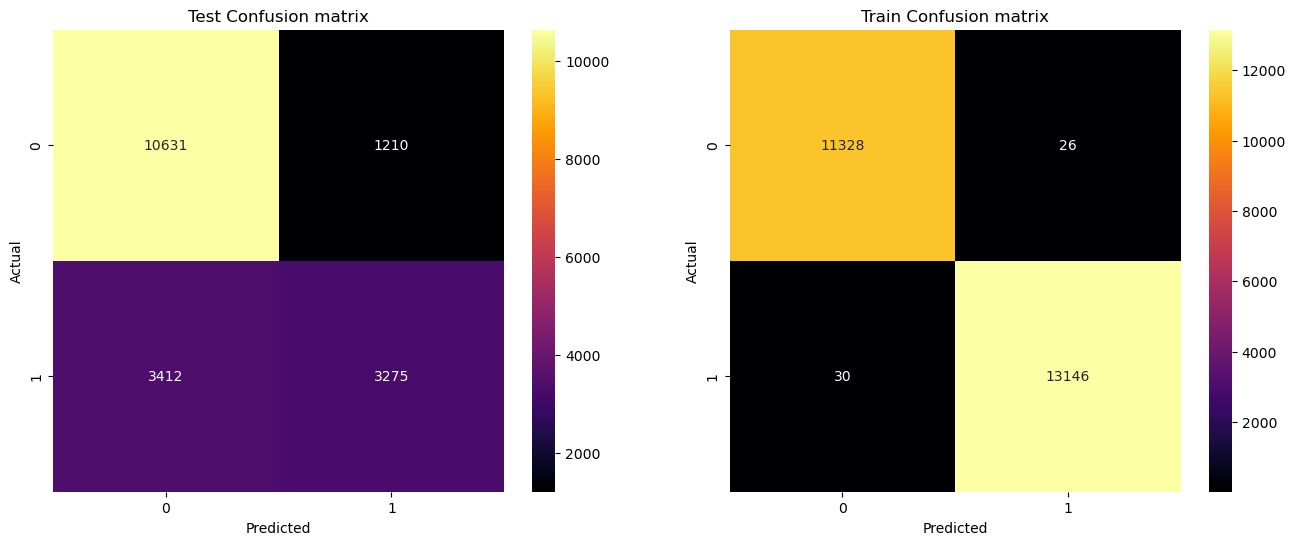

In [52]:
# Confusion Matrix for Test Data
cnf_matrix_test = confusion_matrix(target[target.index.year == 2024], y_pred_bm)
df_cm_test = pd.DataFrame(cnf_matrix_test, columns=np.unique(target[target.index.year == 2024]), index=np.unique(target[target.index.year == 2024]))
df_cm_test.index.name = 'Actual'
df_cm_test.columns.name = 'Predicted'

# Confusion Matrix for Train Data
y_pred_train = best_model.predict(X_train)
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
df_cm_train = pd.DataFrame(cnf_matrix_train, columns=np.unique(y_train), index=np.unique(y_train))
df_cm_train.index.name = 'Actual'
df_cm_train.columns.name = 'Predicted'

# Plot the Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(df_cm_test, cbar=True, cmap="inferno", annot=True, fmt='.0f', ax=ax[0])
ax[0].set_title('Test Confusion matrix')

sns.heatmap(df_cm_train, cbar=True, cmap="inferno", annot=True, fmt='.0f', ax=ax[1])
ax[1].set_title('Train Confusion matrix')

plt.show()


#### Conclusion: Random forest is the best model for deploying for the given dataset.

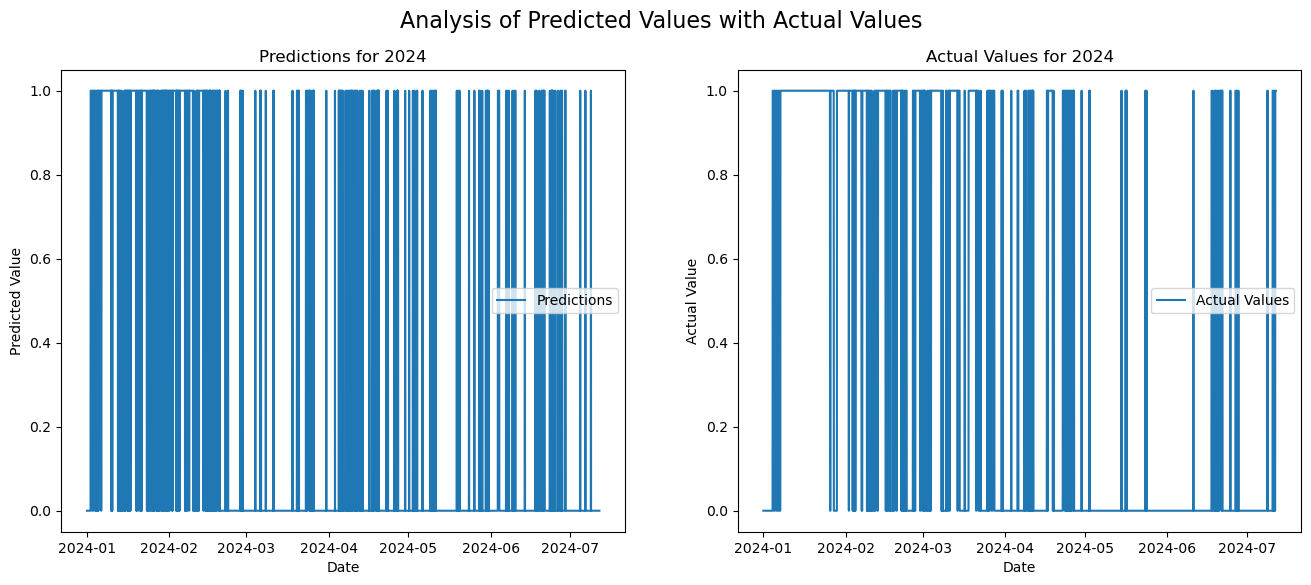

In [53]:
#Further analysis:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(features[features.index.year==2024].index, y_pred_bm, label='Predictions')
ax[0].set_title('Predictions for 2024')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Predicted Value')
ax[0].legend()

ax[1].plot(features[features.index.year==2024].index, target[target.index.year==2024], label='Actual Values')
ax[1].set_title('Actual Values for 2024')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Actual Value')
ax[1].legend()

fig.suptitle("Analysis of Predicted Values with Actual Values", fontsize=16)
plt.show()

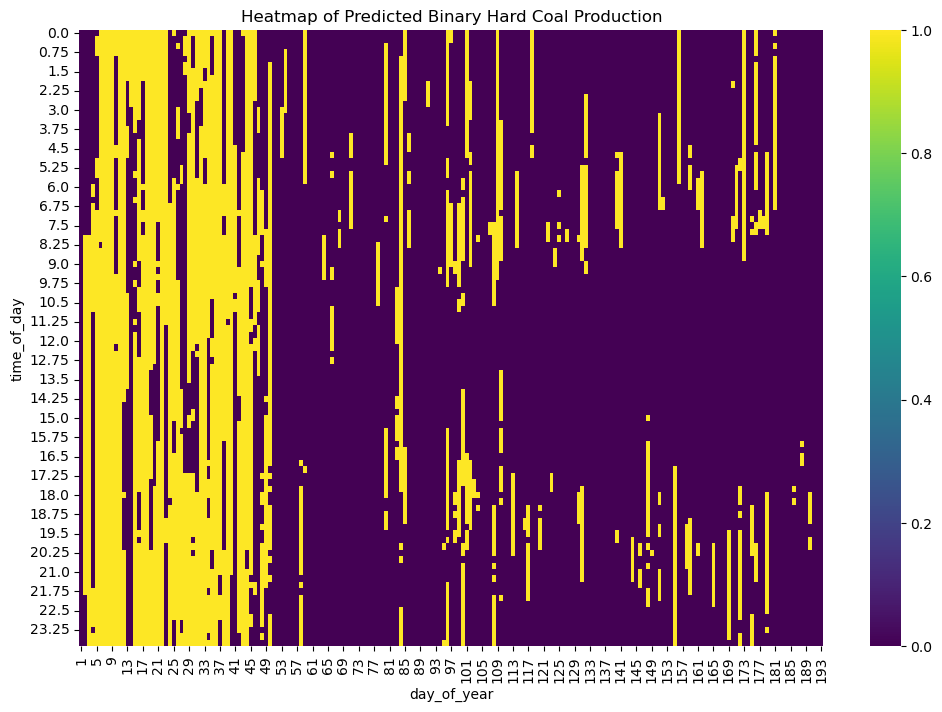

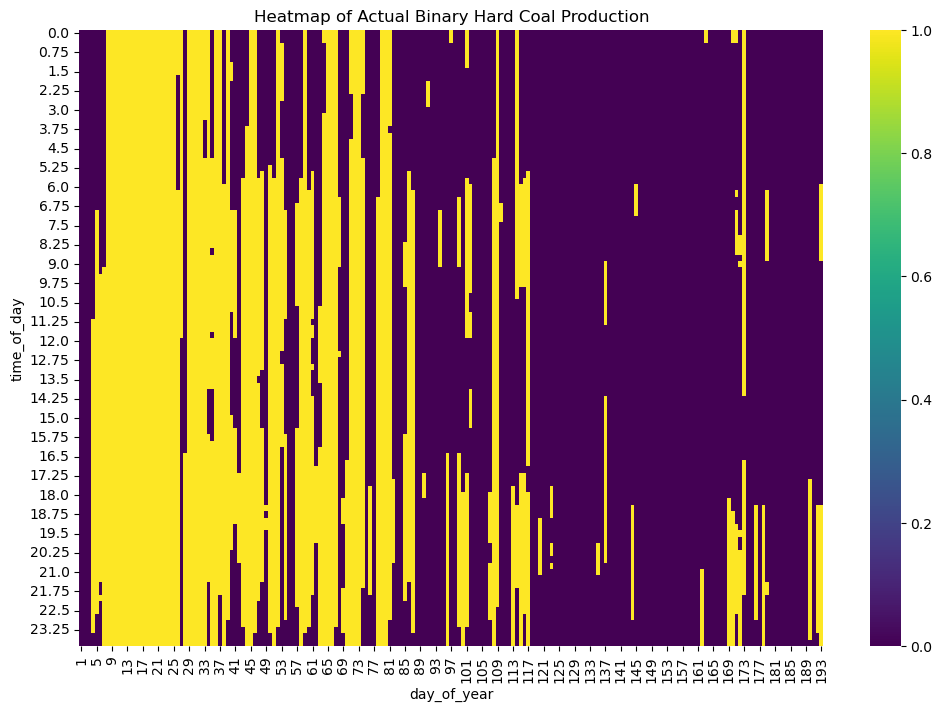

In [54]:
# Heatmap of binary target variable over time
pred_df=features[features.index.year==2024]

# Add day_of_year and time_of_day columns
pred_df['Hard_coal_production_binary_numeric']=y_pred_bm
pred_df['day_of_year'] = pred_df.index.dayofyear
pred_df['time_of_day'] = pred_df.index.hour + pred_df.index.minute / 60


heatmap_data_bin = pred_df.pivot_table(index='time_of_day', columns='day_of_year', values='Hard_coal_production_binary_numeric')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_bin, cmap='viridis')
plt.title('Heatmap of Predicted Binary Hard Coal Production')
plt.show()


# Heatmap of binary target variable over time
act_df=features[features.index.year==2024]

# Add day_of_year and time_of_day columns
act_df['Hard_coal_production_binary_numeric']=target[target.index.year==2024]
act_df['day_of_year'] = pred_df.index.dayofyear
act_df['time_of_day'] = pred_df.index.hour + pred_df.index.minute / 60


heatmap_data_bin = act_df.pivot_table(index='time_of_day', columns='day_of_year', values='Hard_coal_production_binary_numeric')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_bin, cmap='viridis')
plt.title('Heatmap of Actual Binary Hard Coal Production')
plt.show()

#### Conclusion : 

Despite some mismatches, the overall alignment between predicted and actual values is reasonable. This suggests that the model has a good understanding of the production trends, even if it doesn't capture every fluctuation accurately

### Documentation:

#### Percentage of contribution:

##### :- Saurav B: 50%, Nooreldin: 50%


#### Use of ChatGPT and ClaudeAI is mentioned in the comments of the code.

#### Use of lecture codes and Datacamp has been mentioned in the comments of the code.